# Over dit document
In dit document wordt een CRISP-DM cycles doorlopen, welke vervolgens een dataproduct (visualisaties) op zal leveren. Tot slot wordt er een conclusie getrokken en advies gegeven. Dit advies zal worden gedaan aan de hand van het FOETSJE-model, te weten: Financieel, Organisatorisch, Economisch, Technologisch, Sociaal, Juridisch en Ethisch. Hierbij zal het ethische aspect in het kader van de opdracht de meeste nadruk krijgt.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn import linear_model

df=pd.read_excel("Complete-dataset-FINAL.xlsx")


# Business understanding
Het ziekenhuis Isala wil de zorg voor diabetespatiënten verbeteren. Het gaat hier specifiek om het behandelproces door onnauwkeurigheden in metingen te filteren en hierop te baseren of een behandelplan aangepast moet worden of niet. Visualisaties zullen helpen bij het verkrijgen van inzicht van diverse meetmethoden om vervolgens conclusies te kunnen trekken. Die zijn er nog niet. Daarbij zou een visualisatie van een voorspelling meer inzicht brengen in hoe de total error mogelijk zal veranderen per jaar. Dit zou kunnen resulteren in toekomstige plannen voor het standaardiseren van de HbA1c meetmethoden.

Om een voorspelling te realiseren & visualiseren wordt het ARIMA model gebruikt. Als eerste wordt er gekeken naar hoe stationair de data is. Vervolgens zullen de parameters (zie uitleg ARIMA model) voor dit model worden afgestemd op verschillende grafieken, ARIMA(p=?, d=?,q=?). Tot slot zal de voorspelling gevisualiseerd worden.

#### Uitleg ARIMA model
Het doel van een ARIMA model is het nabootsen van een tijdsserie. Dit wordt gedaan door de variaties in de data te modelleren door middel van de volgende drie opties: 

- AR (auto-regressief), voorgaande waardes worden gebruikt om nieuwe waardes te voorspellen.
- I (integrated), niet de originele serie maar een gedifferentieerde tijdsserie wordt gebruikt. Dit om de tijdsserie stationair te maken. 
- MA (moving average), voorafgaande fouten worden gebruikt om nieuwe fouten voorspellen. Dit heeft een smoothing effect, een bewegend gemiddelde. 

Door deze effecten te mengen kun je de meeste tijdsseries nabootsen. In de volgende sectie gaan we de effecten van de AR en MA termen op een tijdsserie bekijken. 

Note

In dit notebook zal er gefocust worden op het ARIMA model. Het aantal metingen per fabrikant verschilt enorm. Daarom wordt er nu gefocust op de top 10 fabrikanten met de meeste metingen.

# Data understanding
Welke databronnen zijn gegeven en in welk formaat:
Een excel bestand genaamd: Complete-dataset-FINAL.xlsx
##### note
Het excel bestand dat gebruikt gaat worden, is het resultaat van rapporten die om zijn gezet naar excel. Dit is de meest recente versie waarin de meetmethoden zijn genormaliseerd en de waarden dubbelgecheckt zijn.

Hoe groot zijn deze databronnen:
355 kB

-4685 rijen

-12 kolommen


Kolomnamen: Method name, N (no. labs), Mean, Bias, CV, Sample, Reference value, Year, Source, Type, Manufacturer (fabrikant).

# Data preparation
De dataset wordt aangepast, zodat het bruikbaar is om tijdsreeksen mee te kunnen voorspellen.

In [49]:
#Check to drop all empty values, adjust column name so it's usable
df=df.dropna()
df.columns = df.columns.str.replace('Total Error', 'Total')
df.columns

Index(['Method name', 'N (no. labs)', 'Mean', 'Bias', 'CV', 'Sample',
       'Reference Value', 'Year', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)',
       'Manufacturer', 'Total'],
      dtype='object')

In [50]:
df.Year.astype('int32')
df['Year'] =pd.to_datetime(df.Year, format='%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4058 entries, 0 to 4683
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Method name          4058 non-null   object        
 1   N (no. labs)         4058 non-null   object        
 2   Mean                 4058 non-null   float64       
 3   Bias                 4058 non-null   float64       
 4   CV                   4058 non-null   float64       
 5   Sample               4058 non-null   object        
 6   Reference Value      4058 non-null   float64       
 7   Year                 4058 non-null   datetime64[ns]
 8   Source (CAP/EurA1c)  4058 non-null   object        
 9   Type (Fresh/frozen)  4058 non-null   object        
 10  Manufacturer         4058 non-null   object        
 11  Total                4058 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(6)
memory usage: 412.1+ KB


In [51]:
df = df.set_index('Year')
df.head()

,Method name,N (no. labs),Mean,Bias,CV,Sample,Reference Value,Source (CAP/EurA1c),Type (Fresh/frozen),Manufacturer,Total
Year,,,,,,,,,,,
2011-01-01,Vitros 5.1 FS. 4600. 5600,183,6.14,-0.16,2.3,GH2-04,6.3,CAP,Fresh,Vitros,4.348
2011-01-01,Vitros 5.1 FS. 4600. 5600,183,7.59,-0.01,2.5,GH2-05,7.6,CAP,Fresh,Vitros,4.890
2011-01-01,Vitros 5.1 FS. 4600. 5600,183,9.42,0.22,3.0,GH2-06,9.2,CAP,Fresh,Vitros,6.100
2012-01-01,Vitros 5.1 FS. 4600. 5600,210,5.42,-0.18,2.3,GH2-01,5.6,CAP,Fresh,Vitros,4.328
2012-01-01,Vitros 5.1 FS. 4600. 5600,210,9.34,-0.06,2.6,GH2-02,9.4,CAP,Fresh,Vitros,5.036


In [52]:
# predict only top 10 manufacturers with most datapoints
list_top10 = df['Manufacturer'].value_counts()[:10].index.tolist()
top10_manufacturers = df.loc[df['Manufacturer'].isin(list_top10)]
top10_manufacturers['Manufacturer'].value_counts()
top10_manufacturers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3737 entries, 2011-01-01 to 2021-01-01
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Method name          3737 non-null   object 
 1   N (no. labs)         3737 non-null   object 
 2   Mean                 3737 non-null   float64
 3   Bias                 3737 non-null   float64
 4   CV                   3737 non-null   float64
 5   Sample               3737 non-null   object 
 6   Reference Value      3737 non-null   float64
 7   Source (CAP/EurA1c)  3737 non-null   object 
 8   Type (Fresh/frozen)  3737 non-null   object 
 9   Manufacturer         3737 non-null   object 
 10  Total                3737 non-null   float64
dtypes: float64(5), object(6)
memory usage: 350.3+ KB


In [53]:
top10_manufacturers=top10_manufacturers[['Manufacturer', 'Total']]
manufacturers = top10_manufacturers.groupby("Manufacturer")
manufacturers.size().nlargest(20)

Manufacturer
Siemens              918
Bio-Rad              667
Roche Diagnostics    605
Beckman Coulter      349
Tosoh                284
Abbott               278
Sebia                201
Trinity Biotech      185
Vitros               139
Alere                111
dtype: int64

Abbott


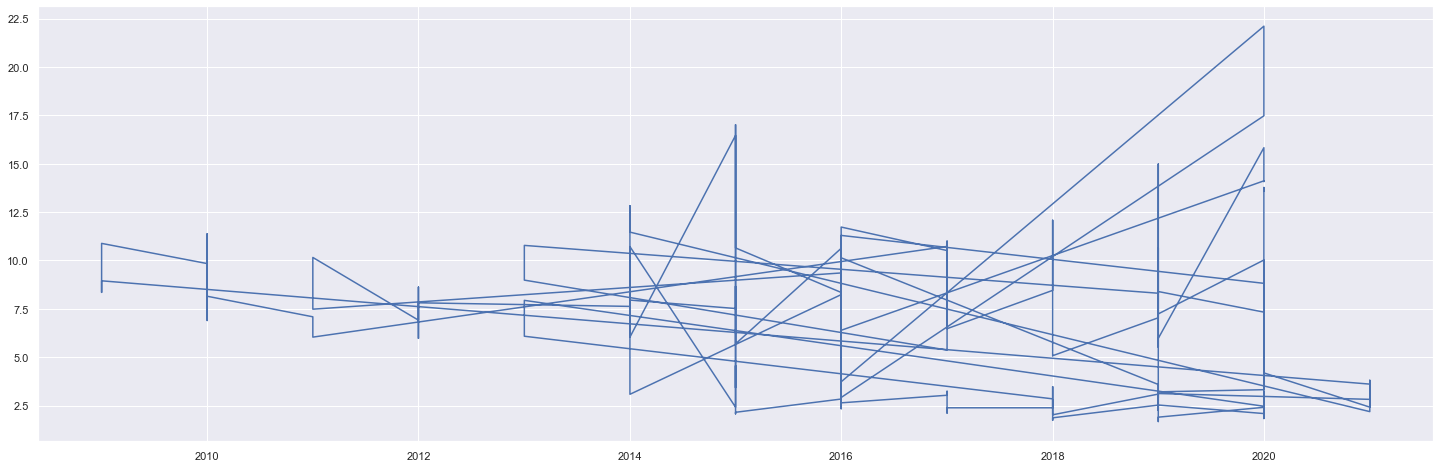

Alere


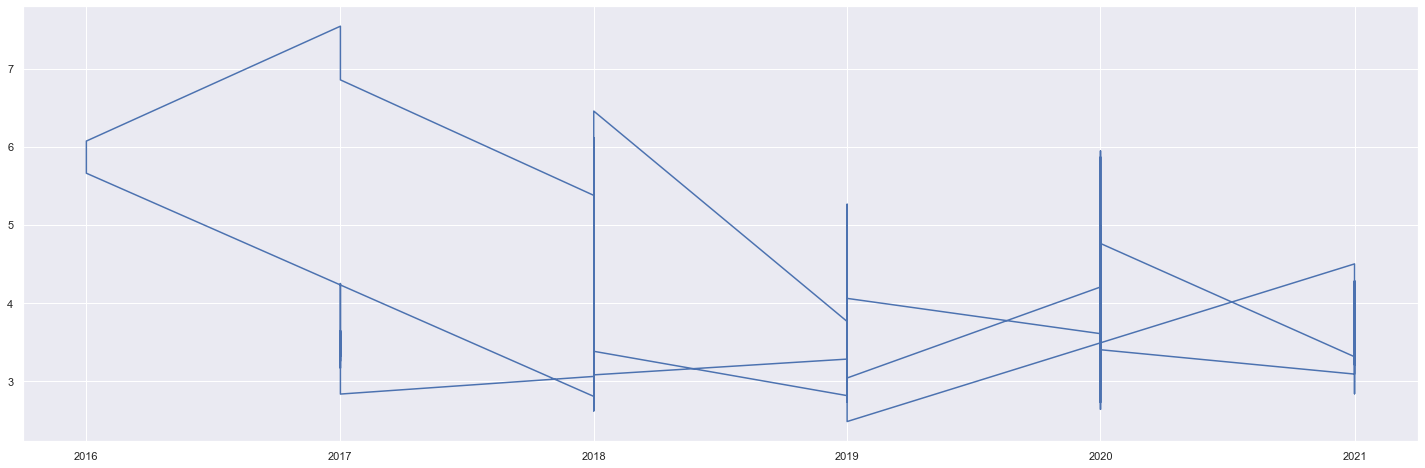

Beckman Coulter


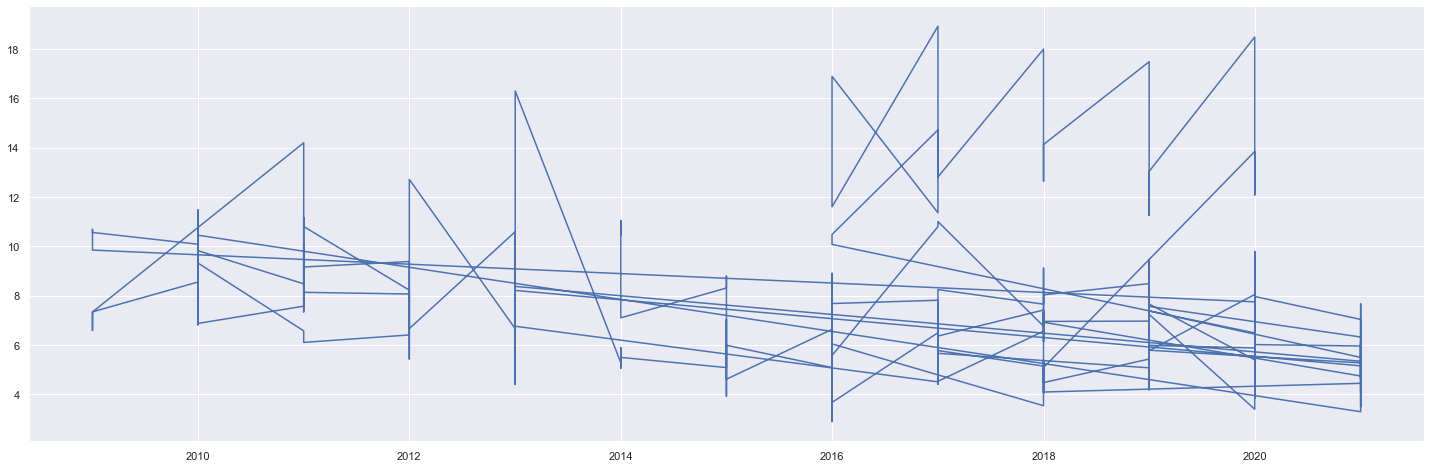

Bio-Rad


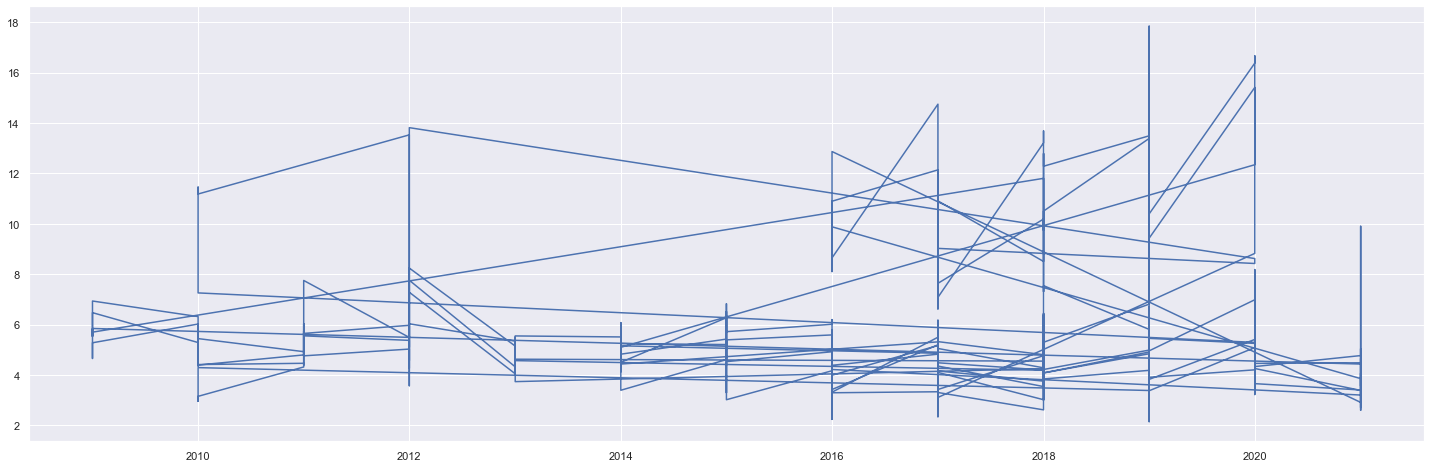

Roche Diagnostics


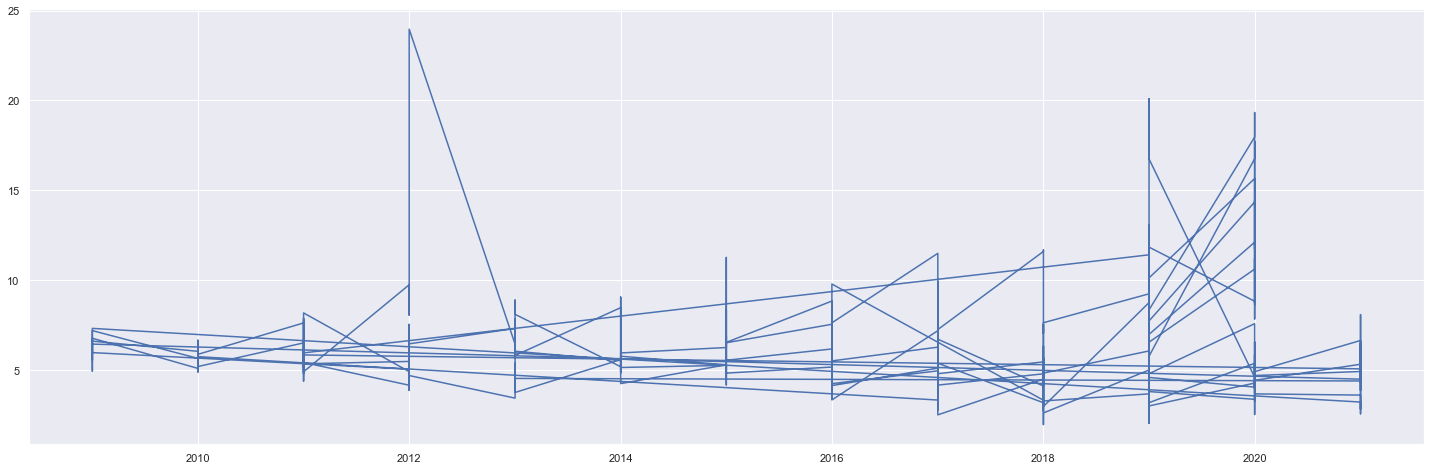

Sebia


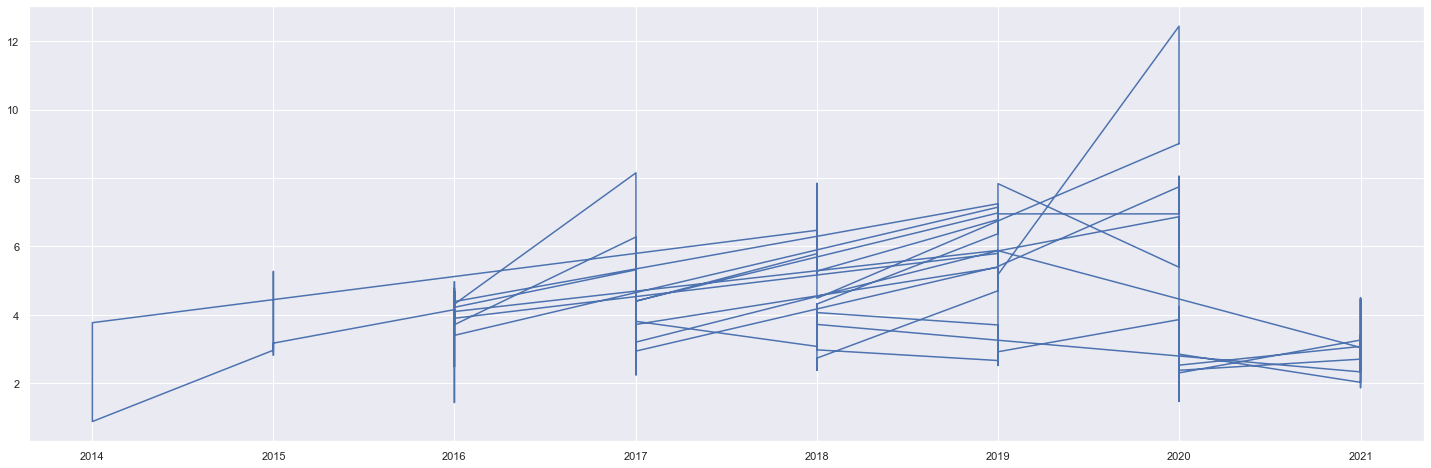

Siemens


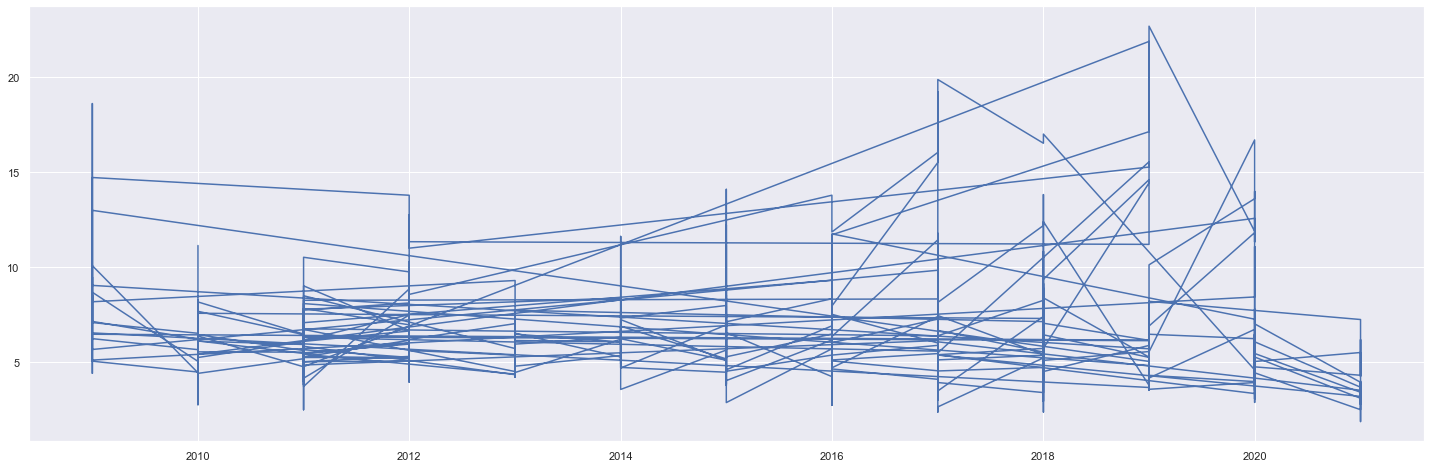

Tosoh


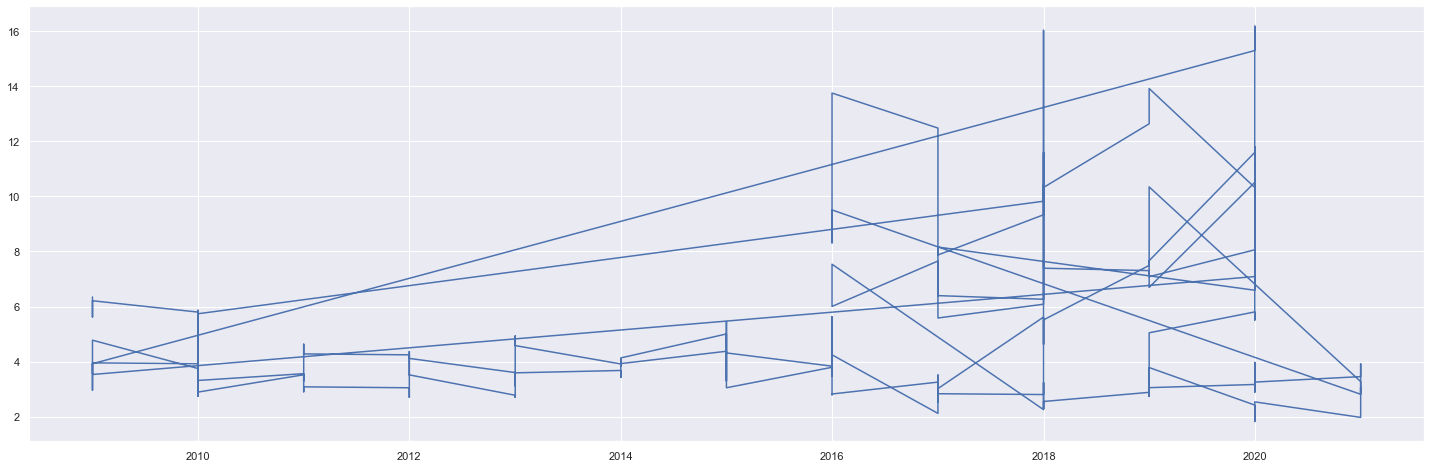

Trinity Biotech


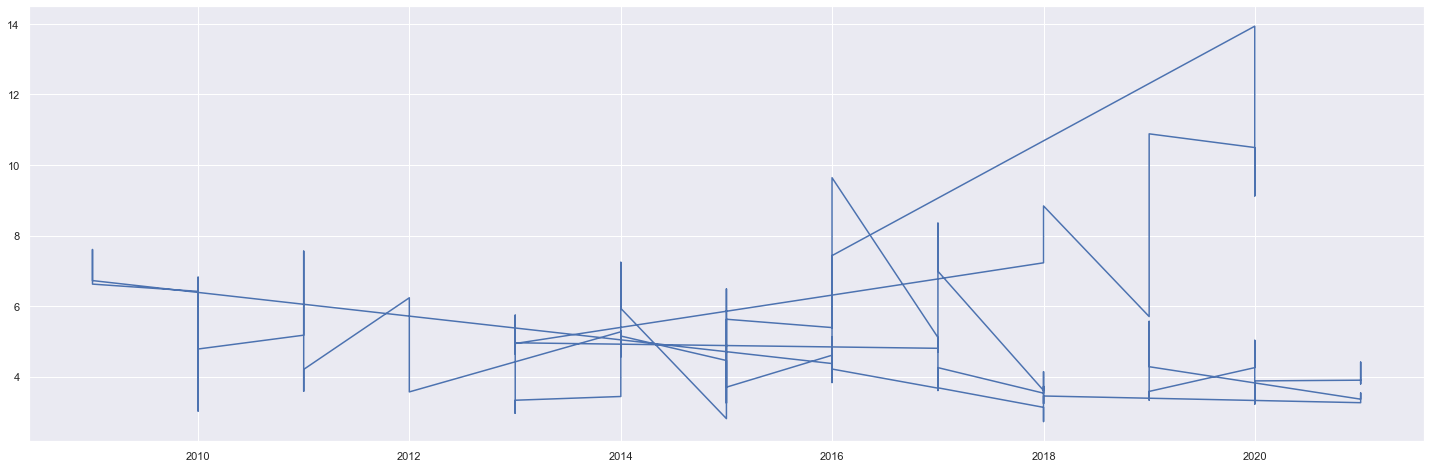

Vitros


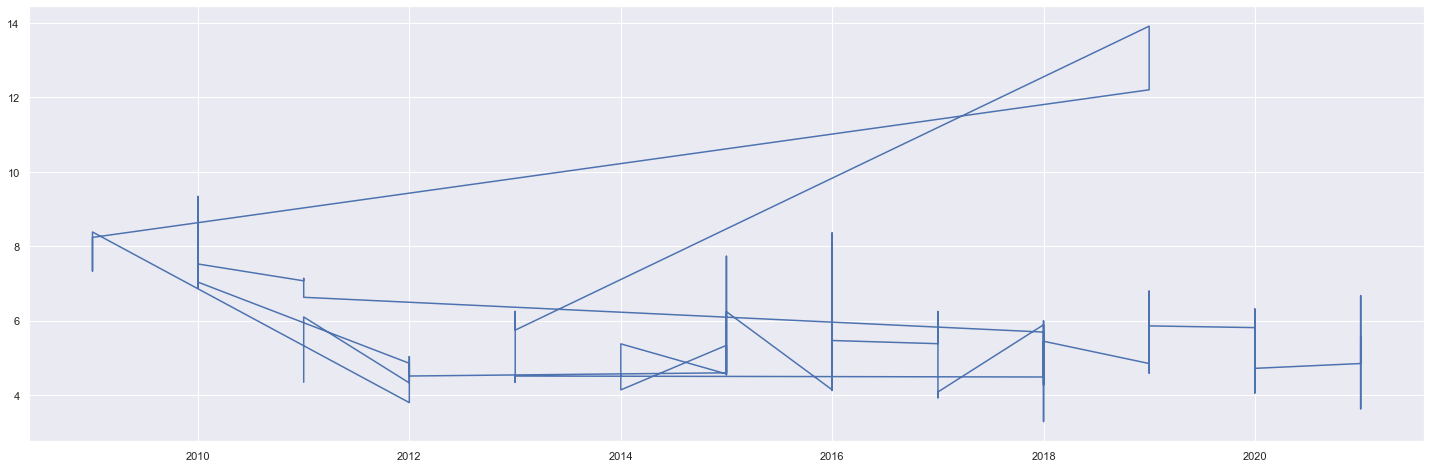

In [54]:
#quick overview of the data
for name, data in manufacturers:
    print(name)
    plt.plot(data.index, data['Total'])
    plt.show()

# Note
Hier is te zien dat er niet een duidelijke lijn wordt weergegeven van door de jaren heen. Dit is een indicatie dat in de dataset de datapunten nog moeten worden gesorteerd. Bij de volgende grafieken zijn de datapunten gesorteerd.

Abbott


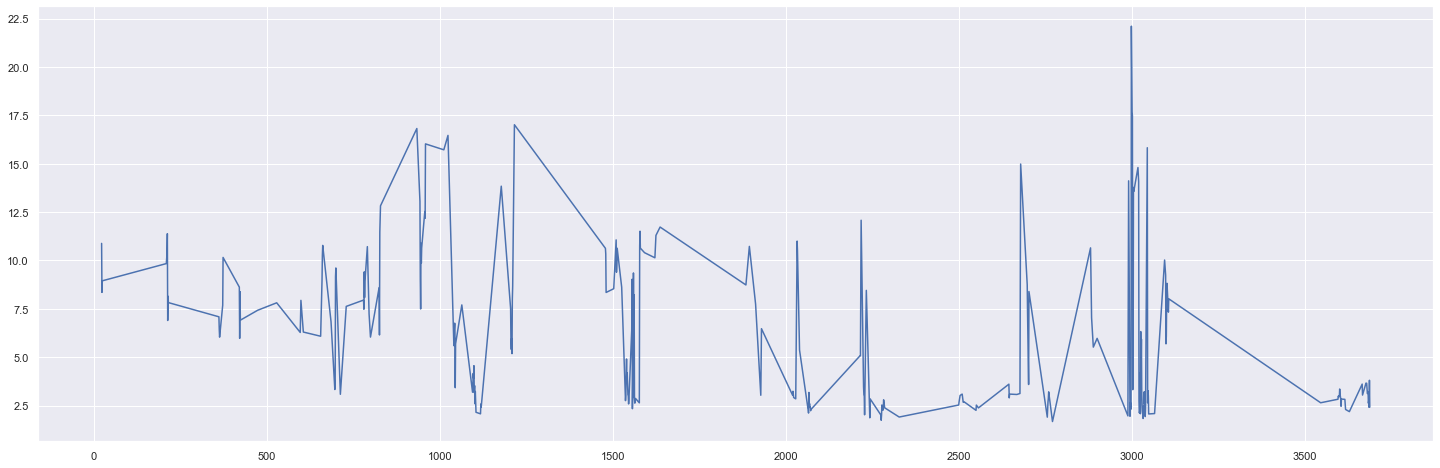

Alere


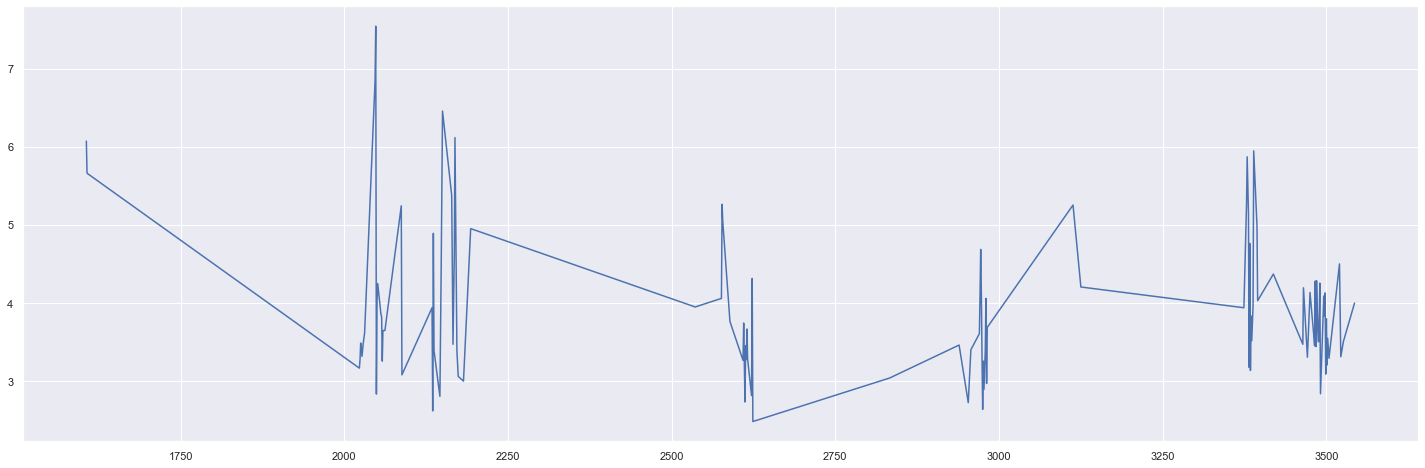

Beckman Coulter


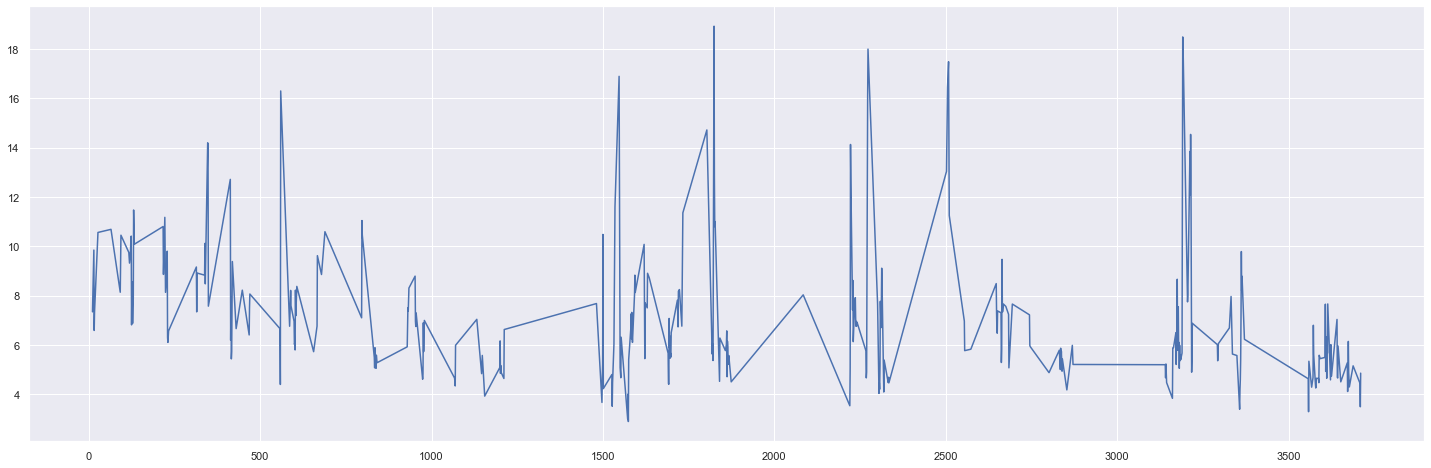

Bio-Rad


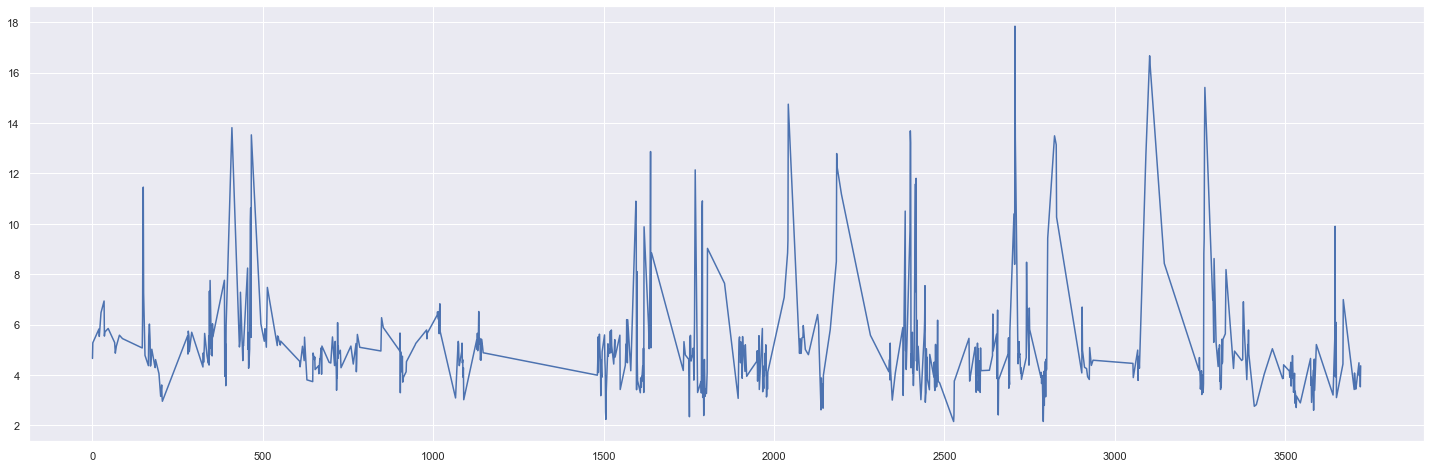

Roche Diagnostics


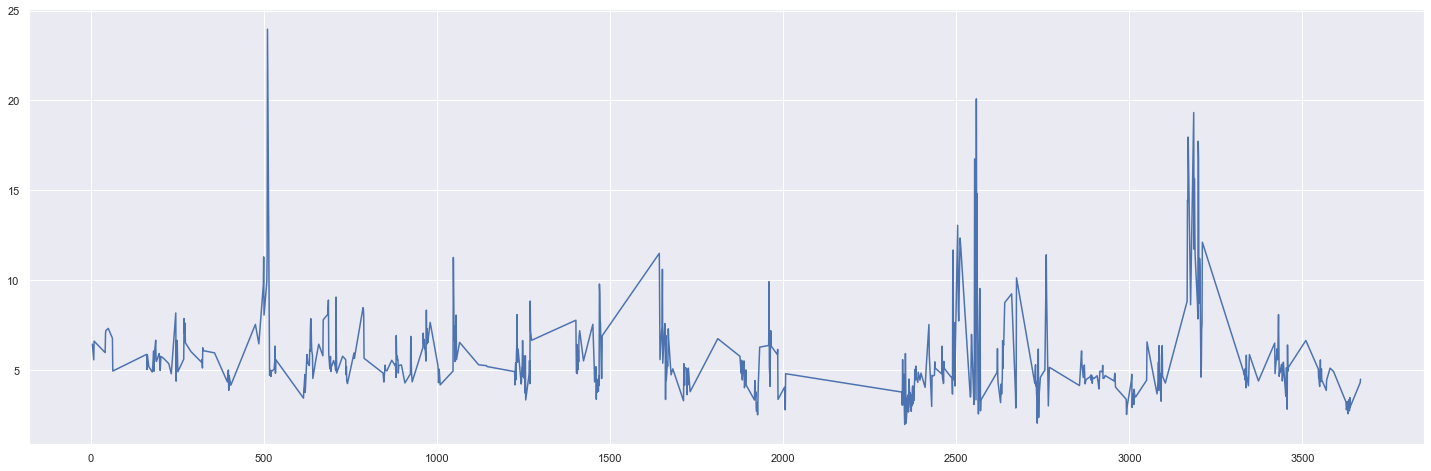

Sebia


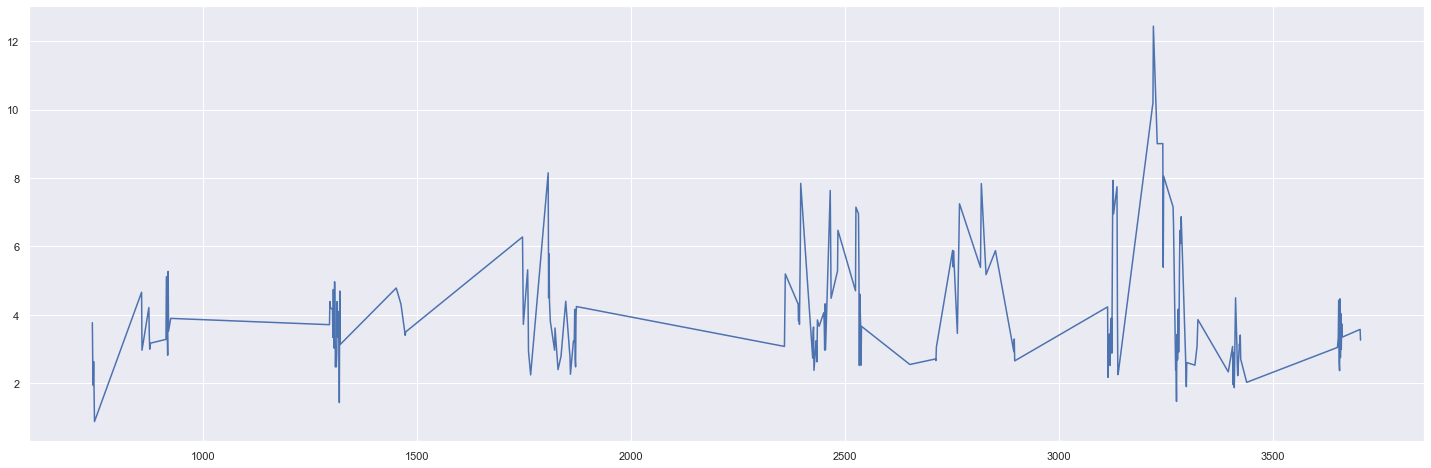

Siemens


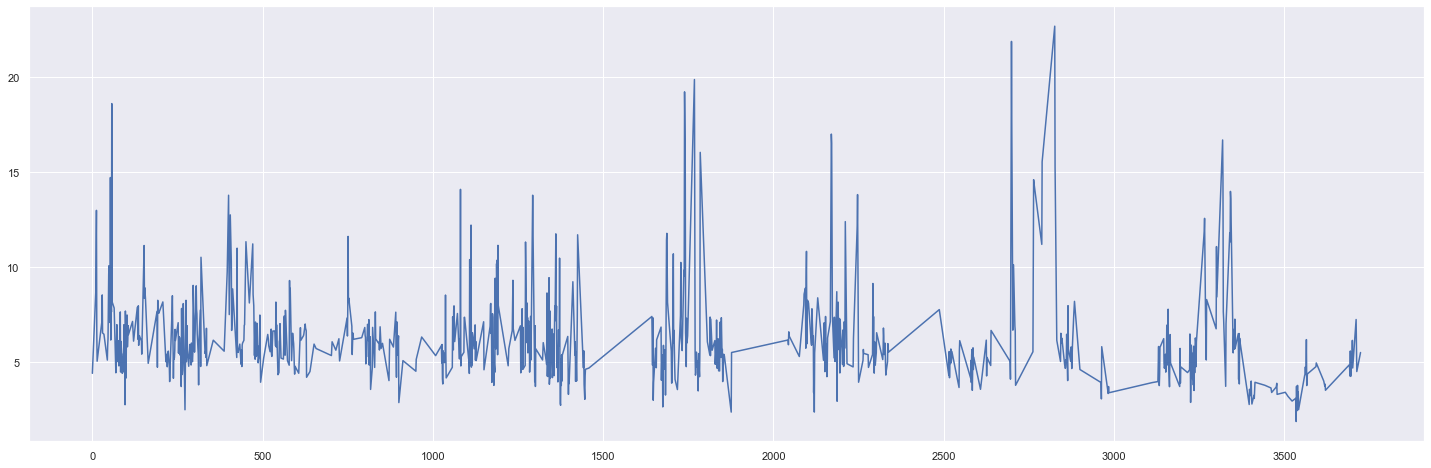

Tosoh


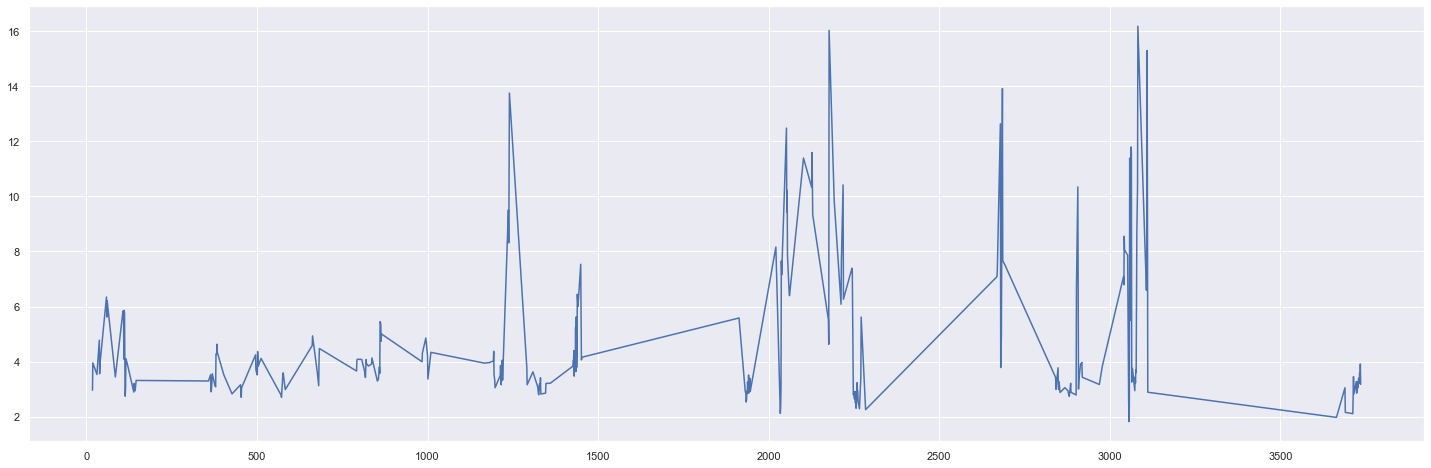

Trinity Biotech


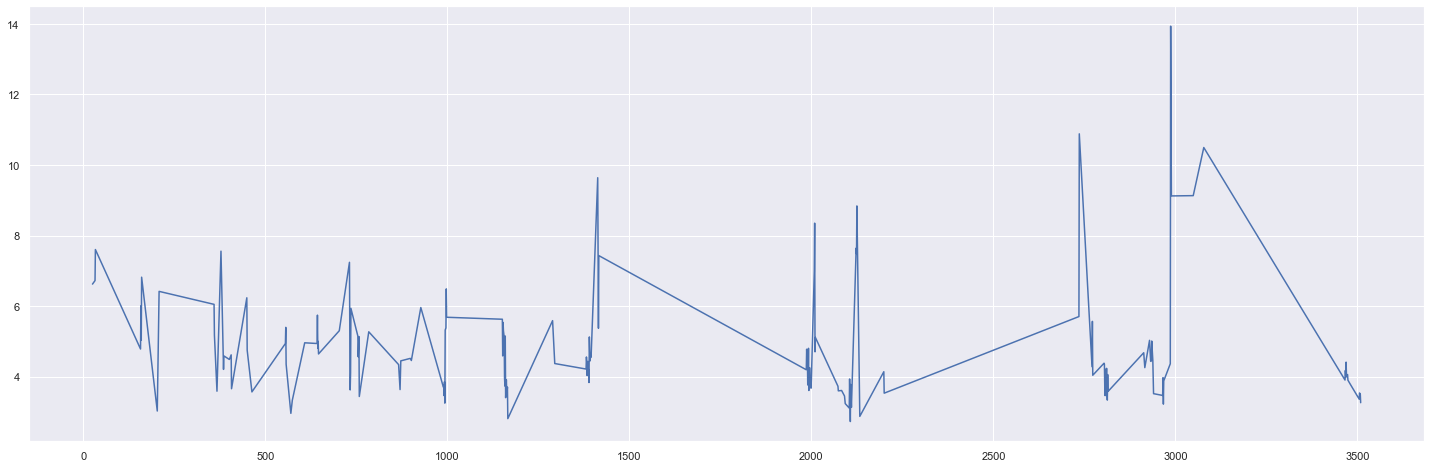

Vitros


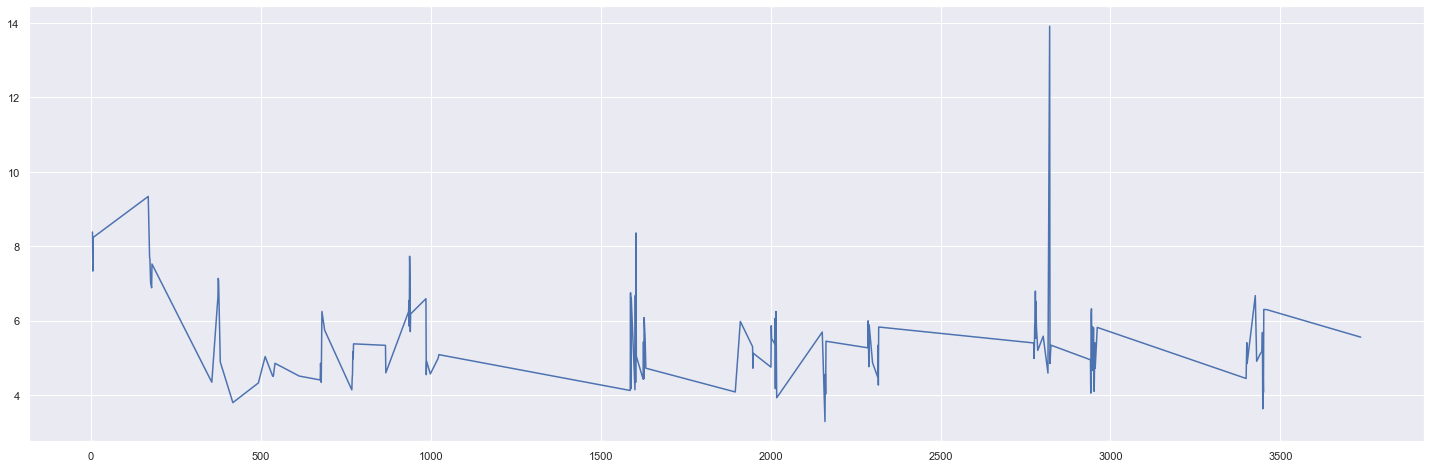

In [55]:
manufacturers_top10 = top10_manufacturers.sort_values(by="Year")
manufacturers_top10 = manufacturers_top10.reset_index()

manufacturers_top10=manufacturers_top10[['Manufacturer', 'Total']]
manufacturers_sorted = manufacturers_top10.groupby("Manufacturer")

for name, data in manufacturers_sorted:
    print(name)
    plt.plot(data.index, data['Total'])
    plt.show()

# Modeling : parameters ARIMA

In [56]:
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series data can said to have stationarity.
from statsmodels.tsa.stattools import adfuller
List_meetmethoden = []


#AIC input is to compute the optimal number iteratively.
for name, data in manufacturers: 
    data= data.dropna()
    print(name) 
    df_stationarityTest = adfuller(data['Total'], autolag='AIC')    
    
    # data['Total'].plot(figsize=(16,10))
    # plt.show() 
    print("\n")
    print(f'ADF Statistic: {df_stationarityTest[0]}')
    print(f'n_lags: {df_stationarityTest[1]}')
    print(f'p-value: {df_stationarityTest[1]}')
    for key, value in df_stationarityTest[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')    

    
    if df_stationarityTest[1] > 0.05:
        List_meetmethoden.append(name)
    print("\n")

print("Meetmethoden met een p-waarden boven de 0.05:")
List_meetmethoden

Abbott


ADF Statistic: -1.9898120102862134
n_lags: 0.29105796634827763
p-value: 0.29105796634827763
Critial Values:
   1%, -3.4554613060274972
Critial Values:
   5%, -2.8725931472675046
Critial Values:
   10%, -2.5726600403359887


Alere


ADF Statistic: -4.340042847938978
n_lags: 0.0003783913537194656
p-value: 0.0003783913537194656
Critial Values:
   1%, -3.49181775886872
Critial Values:
   5%, -2.8884437992971588
Critial Values:
   10%, -2.5811201893779985


Beckman Coulter


ADF Statistic: -3.2663735133490923
n_lags: 0.016450142108014498
p-value: 0.016450142108014498
Critial Values:
   1%, -3.4495033946549123
Critial Values:
   5%, -2.8699787979596136
Critial Values:
   10%, -2.5712658305164955


Bio-Rad


ADF Statistic: -5.086968935872926
n_lags: 1.4889943958397245e-05
p-value: 1.4889943958397245e-05
Critial Values:
   1%, -3.4405132737812596
Critial Values:
   5%, -2.8660244429195725
Critial Values:
   10%, -2.5691581552588447


Roche Diagnostics


ADF Statistic: -2.4792452298597

['Abbott', 'Roche Diagnostics']

### Analyse van p-values
Bij een p-value van 0.05 of er onder, betekent het dat je met zekerheid kan zeggen dat er een relatie is. Wanneer de p-value hoger is dan 0.05 betekent het dat er een kans is op een nulhypothese (voorspelling met geen effect of enige relatie).
Om deze meetmethoden onder de 0.05 te krijgen, wordt het gedifferentieerd. 

#### Differentiatie van meetmethoden met p-value > 0.05

In [66]:
#Één keer diffrentiëren
for name, data in manufacturers:
    if name in List_meetmethoden:
        print("\n" + name) 
        df_stationarityTest = adfuller(data['Total'].diff().dropna(), autolag='AIC')   
        # data['Total'].diff().plot(figsize=(16,10))
        plt.show() 
        
        print("")
        print(f'ADF Statistic: {df_stationarityTest[0]}')
        print(f'n_lags: {df_stationarityTest[1]}')
        print(f'p-value: {df_stationarityTest[1]}')
        for key, value in df_stationarityTest[4].items():
            print('Critial Values:')
            print(f'   {key}, {value}')    

        


Abbott

ADF Statistic: -5.469566816634822
n_lags: 2.4157069378753383e-06
p-value: 2.4157069378753383e-06
Critial Values:
   1%, -3.4554613060274972
Critial Values:
   5%, -2.8725931472675046
Critial Values:
   10%, -2.5726600403359887

Roche Diagnostics

ADF Statistic: -11.397196142263832
n_lags: 7.805836700751158e-21
p-value: 7.805836700751158e-21
Critial Values:
   1%, -3.4414256033746606
Critial Values:
   5%, -2.8664262627821473
Critial Values:
   10%, -2.569372254520843


In [58]:
#2x diff = I (ARIMA)
for name, data in manufacturers:
    if name in List_meetmethoden:
        print("\n")
        print(name) 
        # data['Total'].diff().diff().plot(figsize=(16,10))
        # plt.show()
        data_diff = data['Total'].diff().diff().dropna()
        
        df_stationarityTest = adfuller(data_diff, autolag='AIC')    

        print(f'ADF Statistic: {df_stationarityTest[0]}')
        print(f'n_lags: {df_stationarityTest[1]}')
        print(f'p-value: {df_stationarityTest[1]}')
        for key, value in df_stationarityTest[4].items():
            print('Critial Values:')
            print(f'   {key}, {value}')    




Abbott
ADF Statistic: -8.002101000544423
n_lags: 2.319181934104945e-12
p-value: 2.319181934104945e-12
Critial Values:
   1%, -3.4556556713934934
Critial Values:
   5%, -2.872678352489859
Critial Values:
   10%, -2.57270548832225


Roche Diagnostics
ADF Statistic: -12.62780788192685
n_lags: 1.5279897917157498e-23
p-value: 1.5279897917157498e-23
Critial Values:
   1%, -3.4415584920942424
Critial Values:
   5%, -2.866484781324317
Critial Values:
   10%, -2.569403436033035



# Conclusie p-waarden
Hier is te zien dat bij twee keer differentiëren dat de p-waarden juist groter worden. Voor het ARIMA model nemen we de kleinste p-waarde. Daarom nemen we 0 als parameter bij alle meetmethoden. Dus ARIMA(p=?,d=0,q=?)


# ACF & PACF

### ACF plot

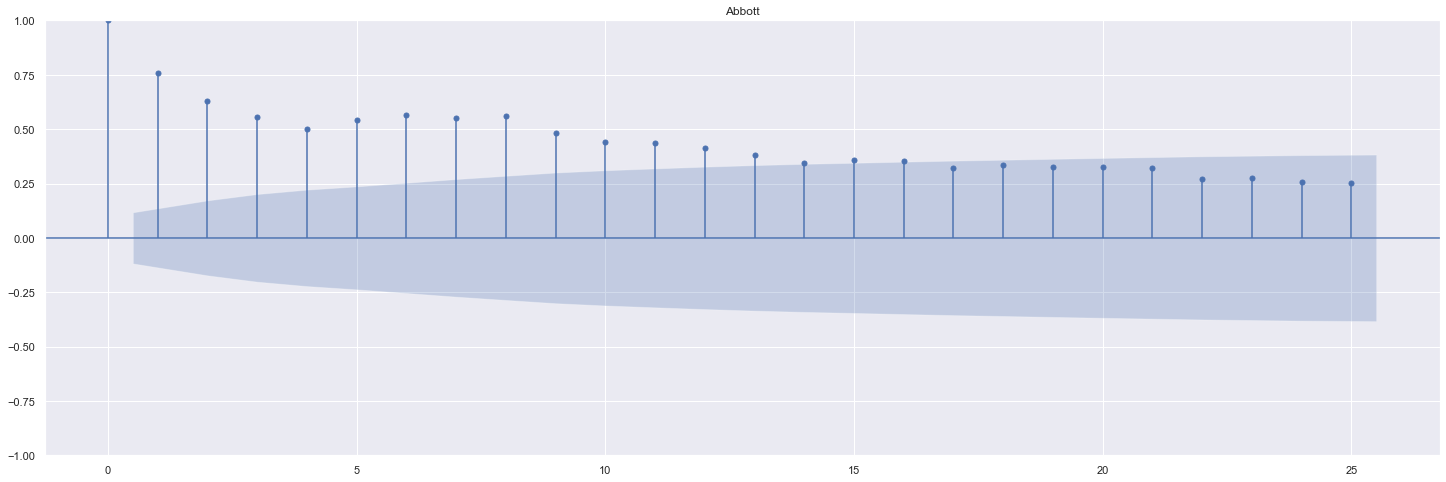

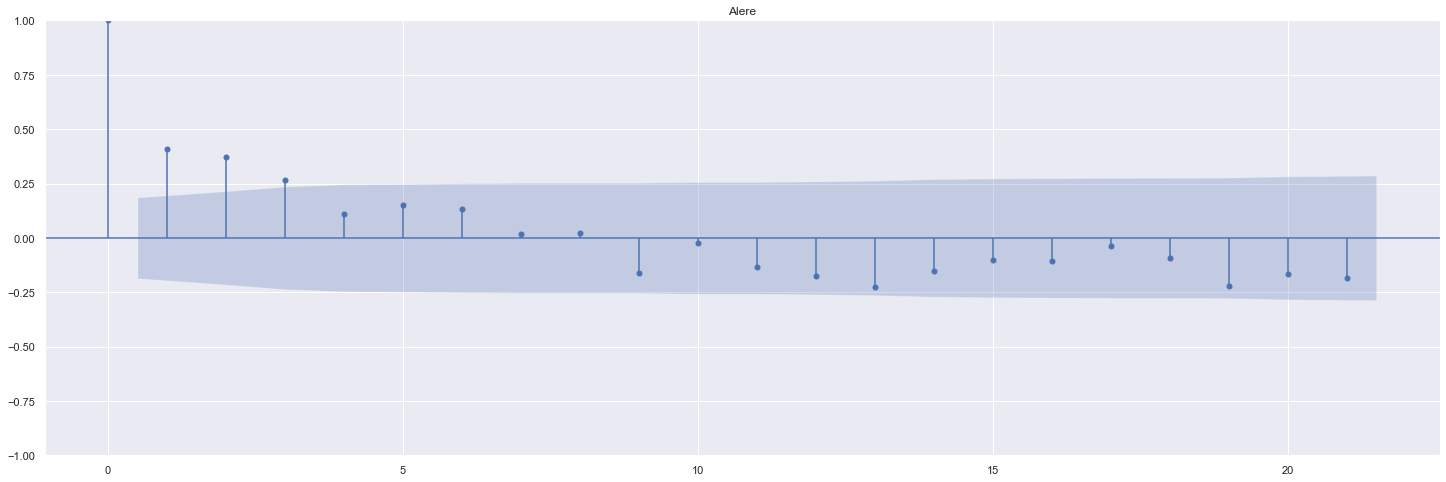

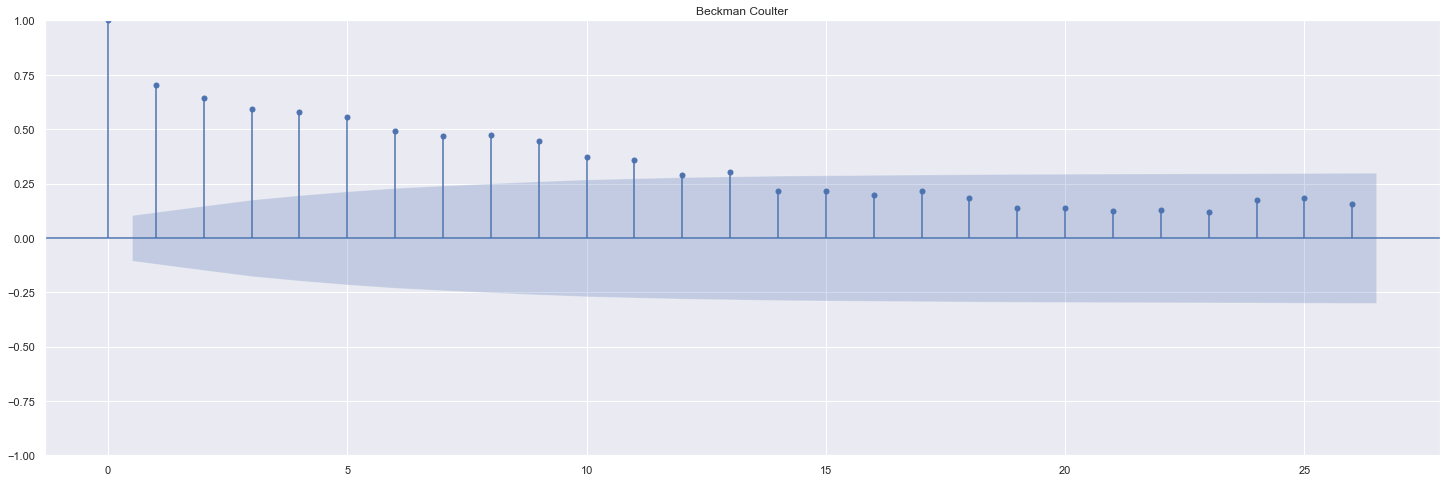

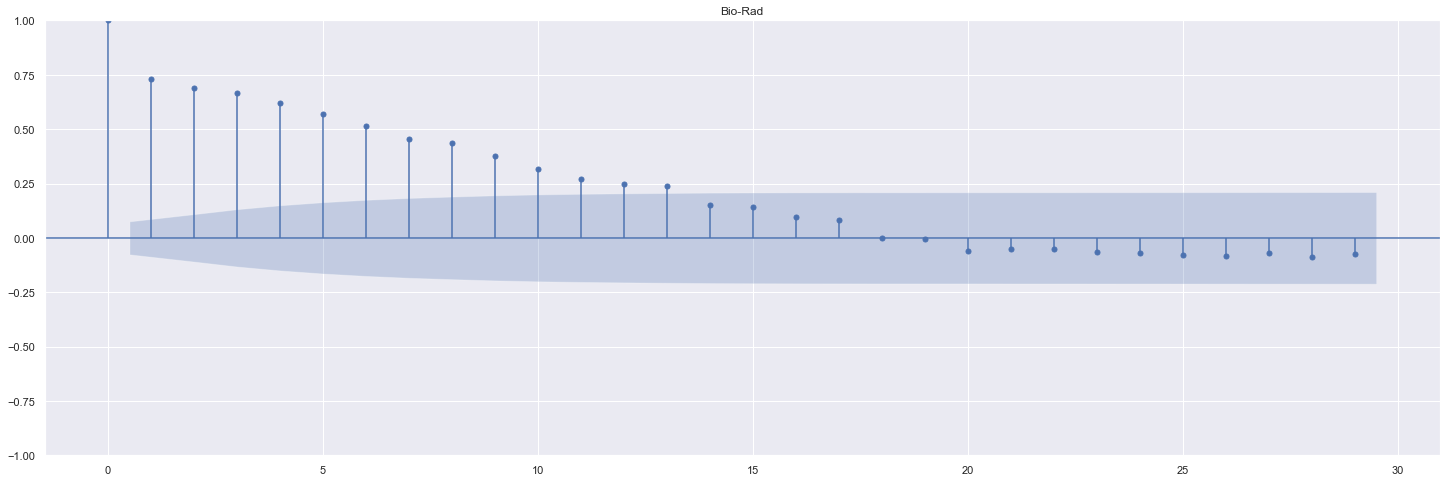

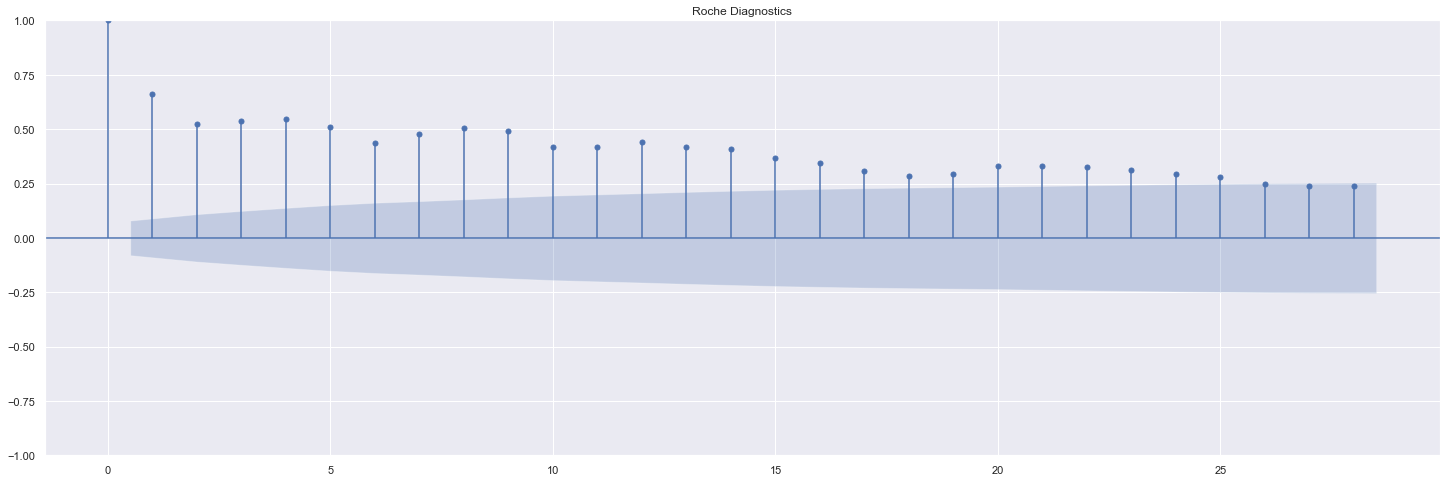

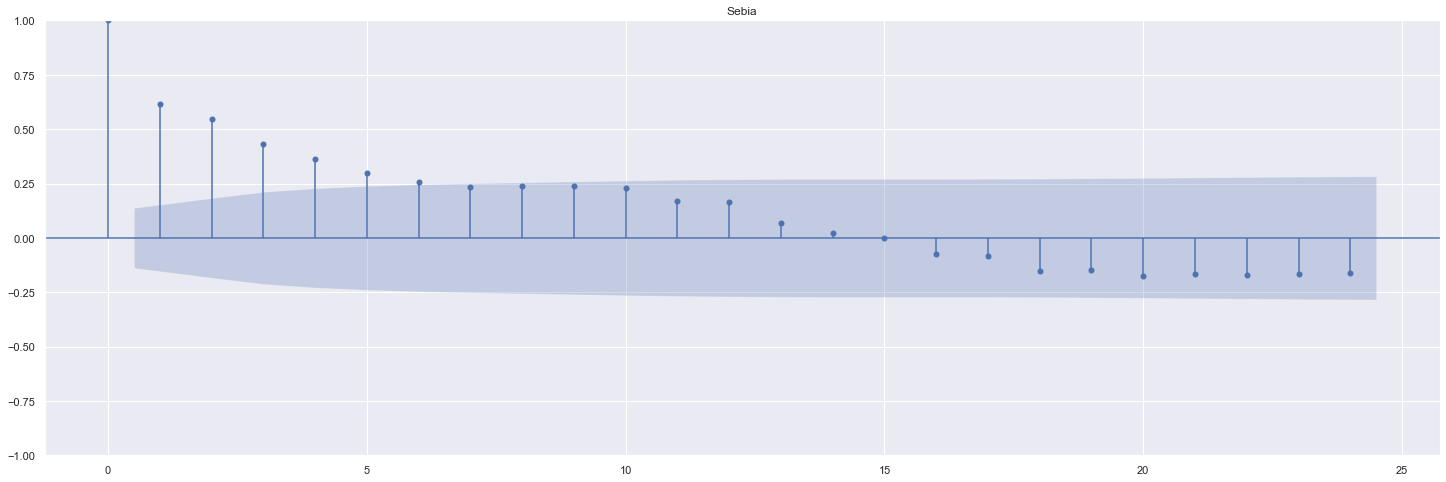

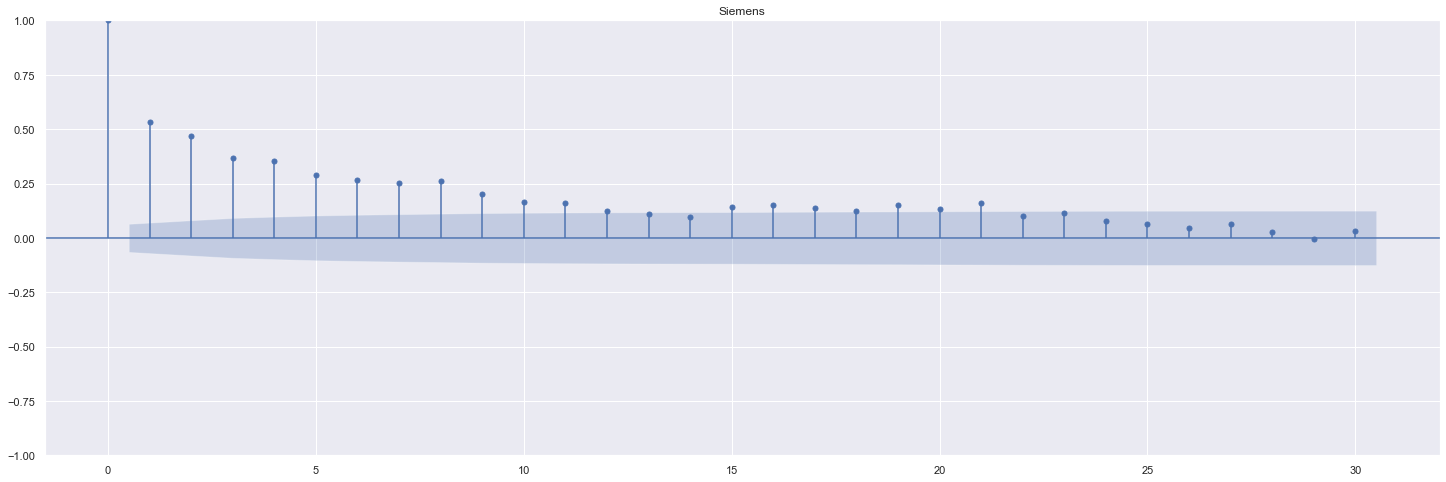

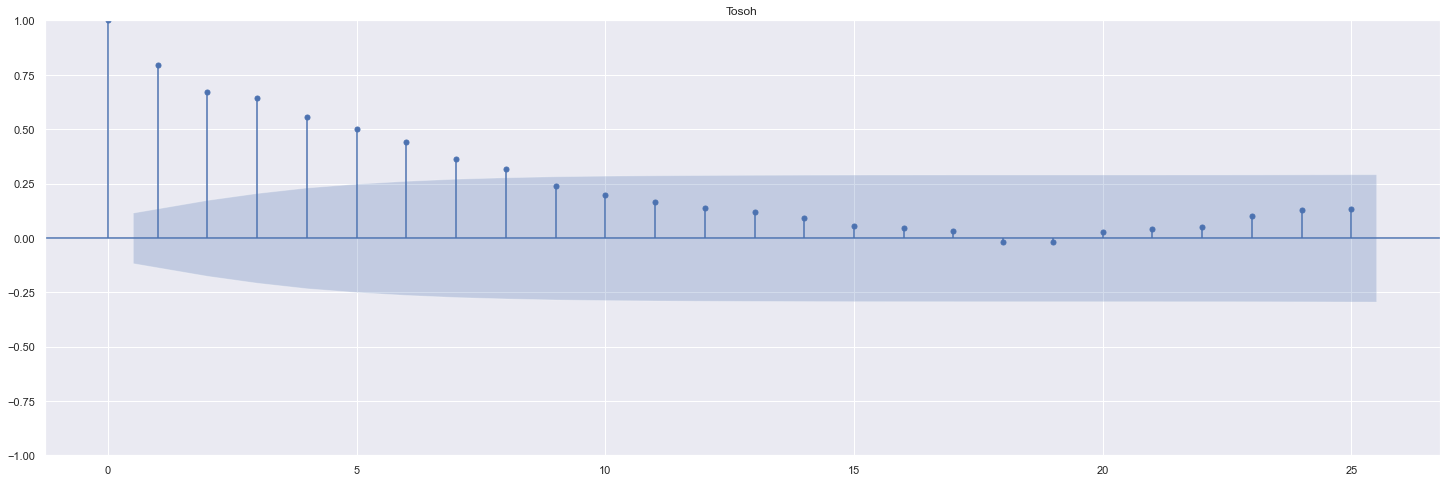

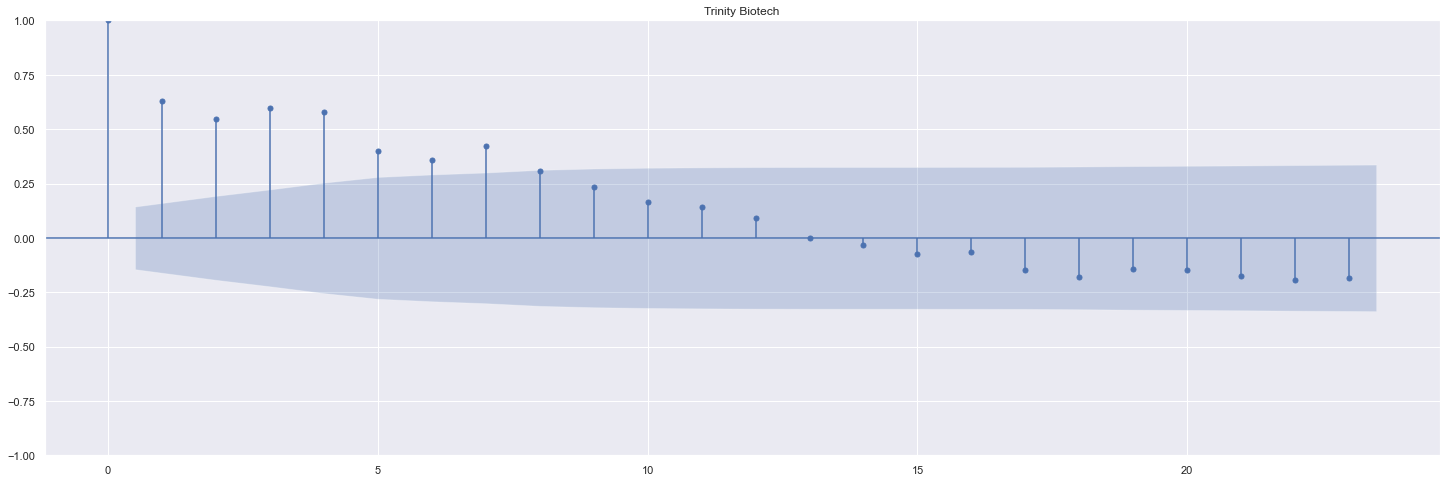

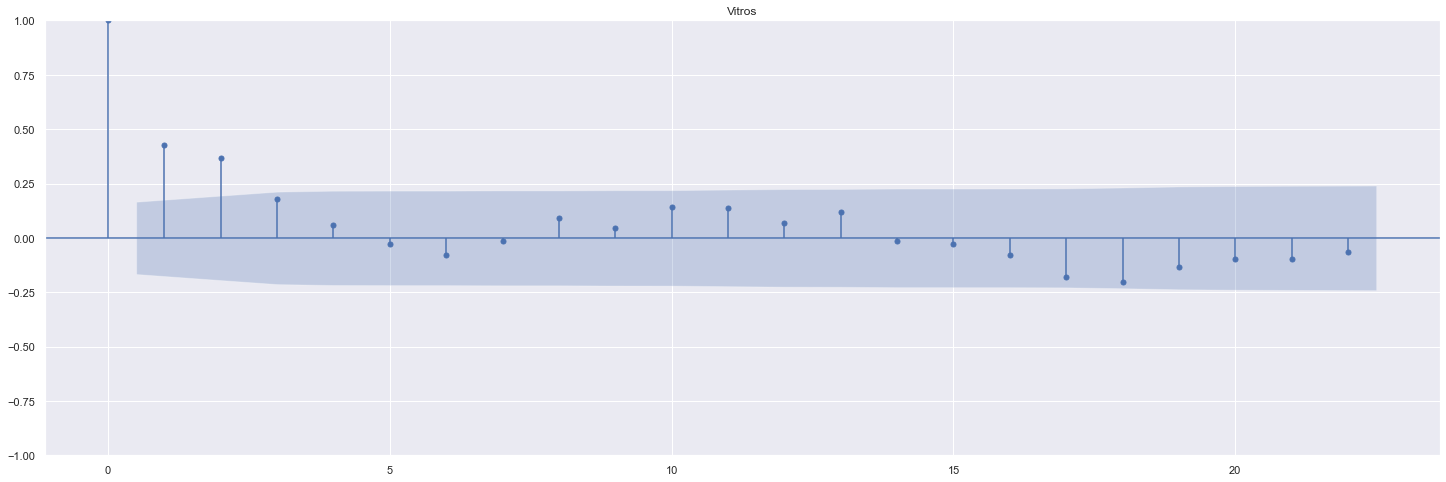

In [59]:
from statsmodels.graphics.tsaplots import plot_acf
for name, data in manufacturers: 
    acf =plot_acf(data['Total'], title=name, alpha=.05)
    

### Analyse van ACF plot
In dit autocorrelatieplot liggen bijna alle waardes buiten het lichtblauwe onzekerheidsgebied (deze variantie in autocorrelatie kan mogelijk ook worden verklaard door ruis). Daarnaast zijn de meeste punten positief. Dit betekent dat we juist wel moeten differentiëren.


juist WEL een MA-parameter moeten in stellen (datapunten buiten het onzekerheidgebied). Daarbij is er per methode een andere MA waarde.


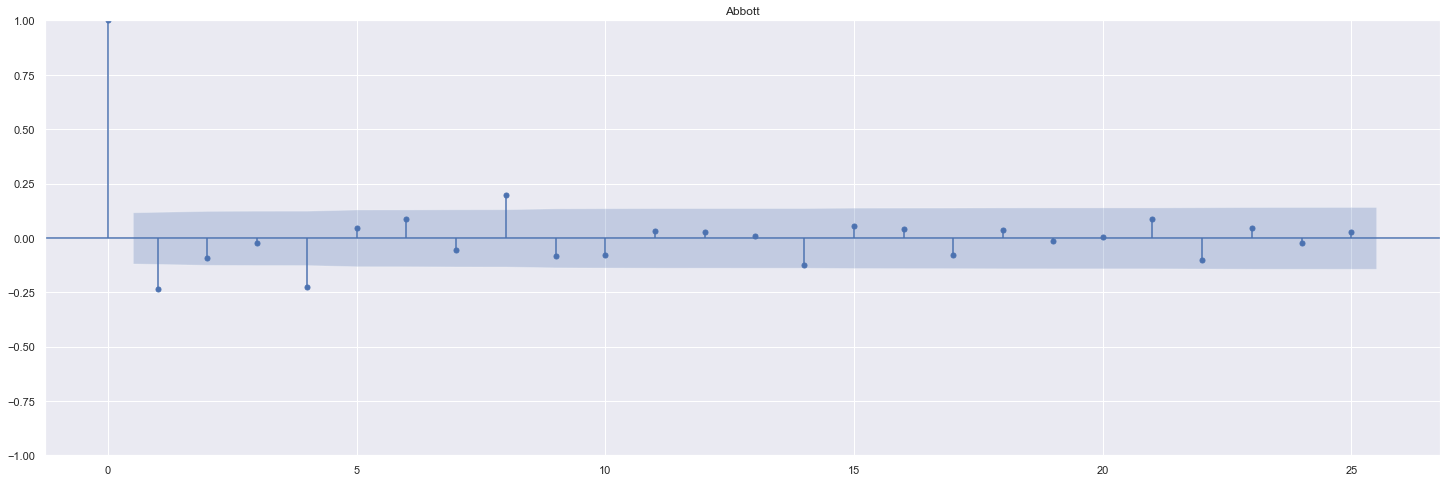

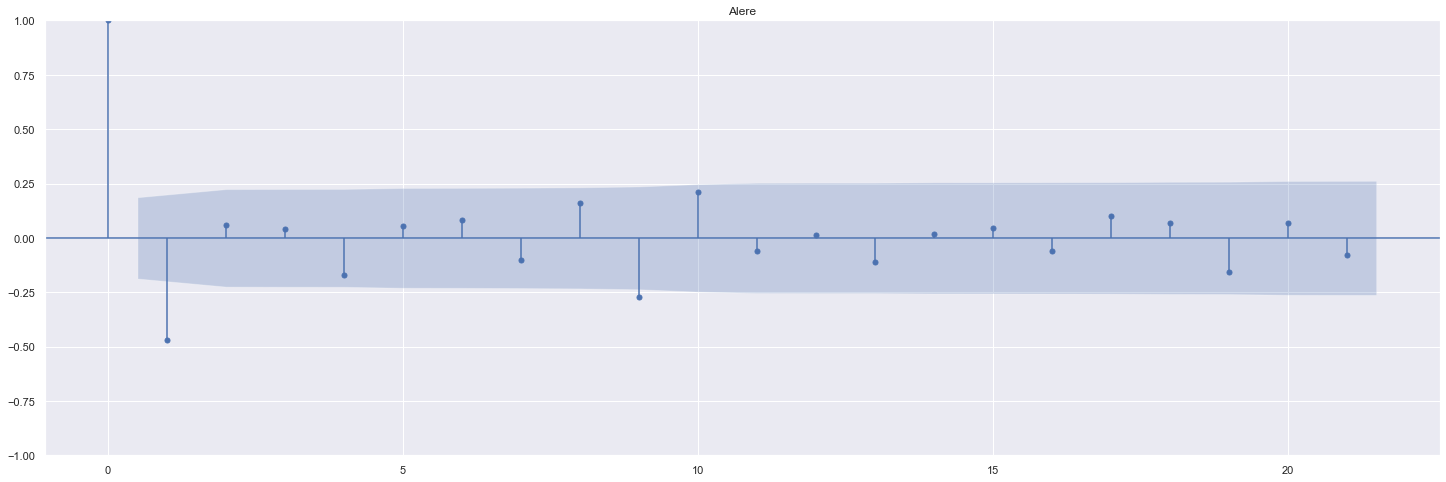

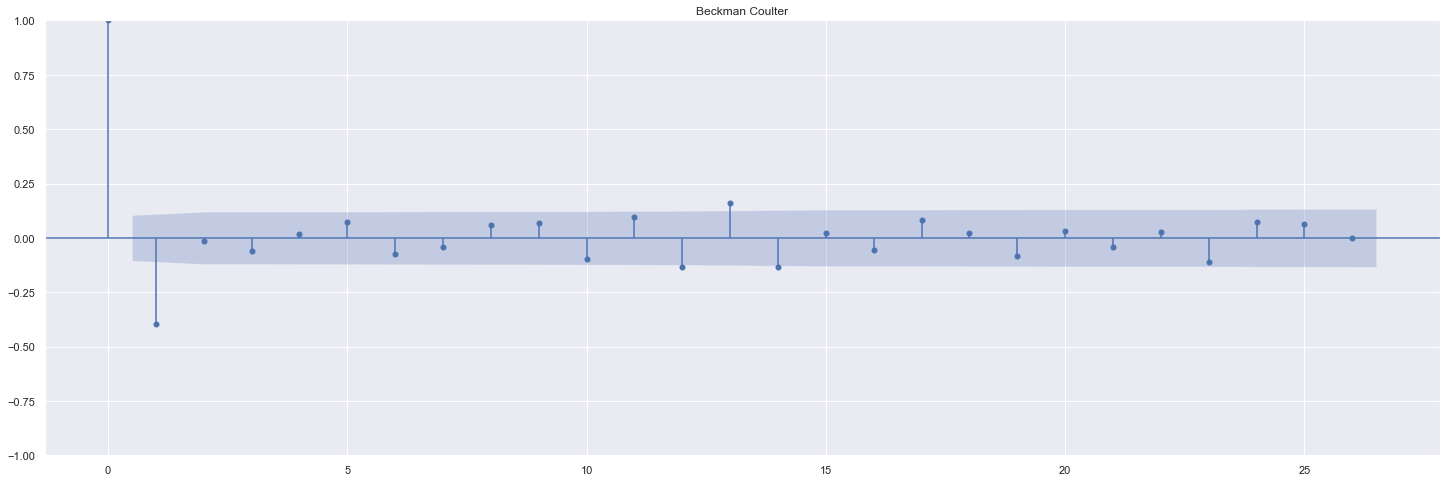

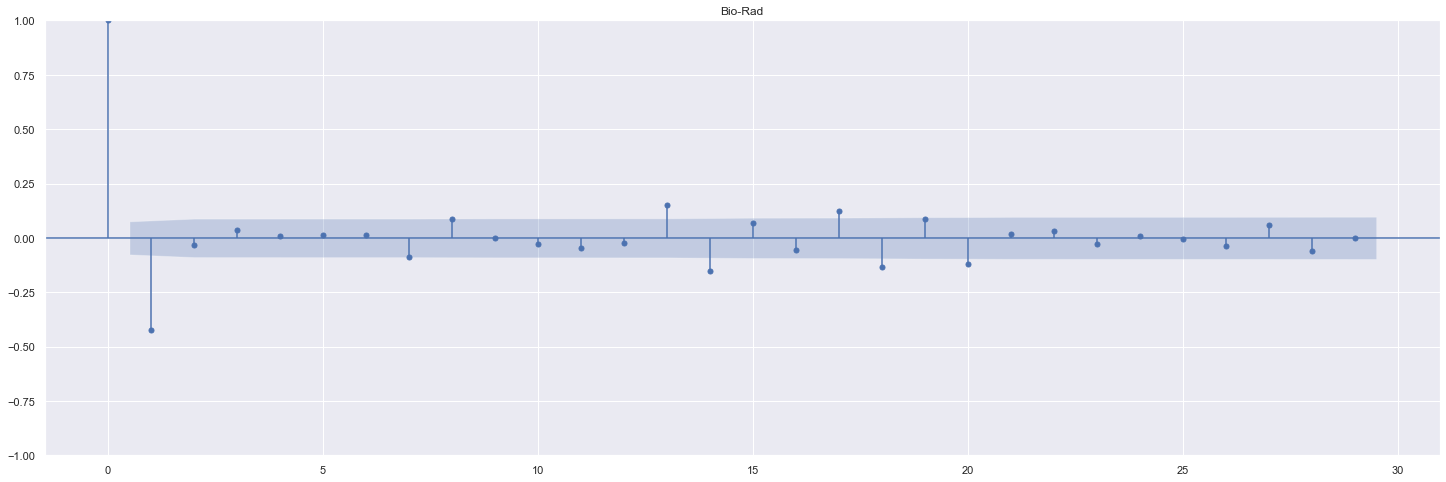

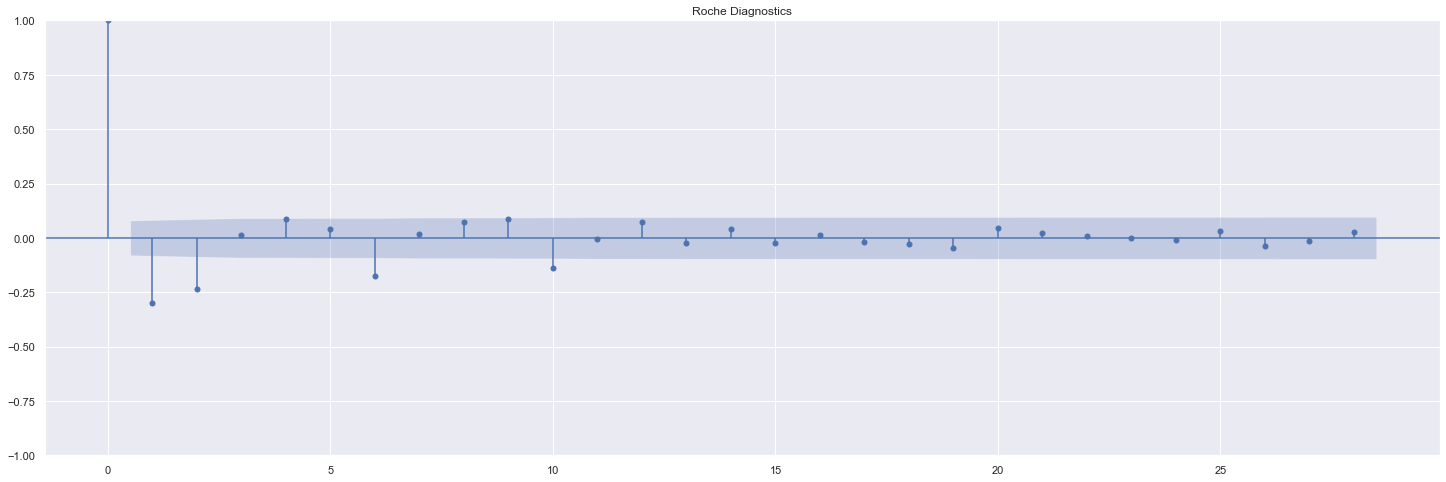

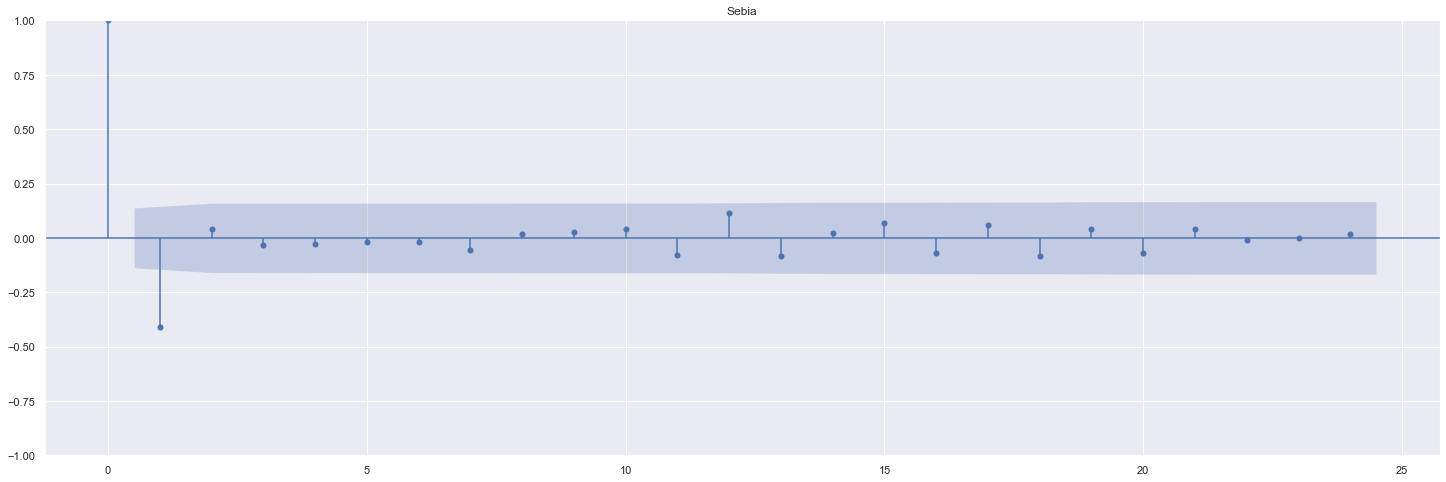

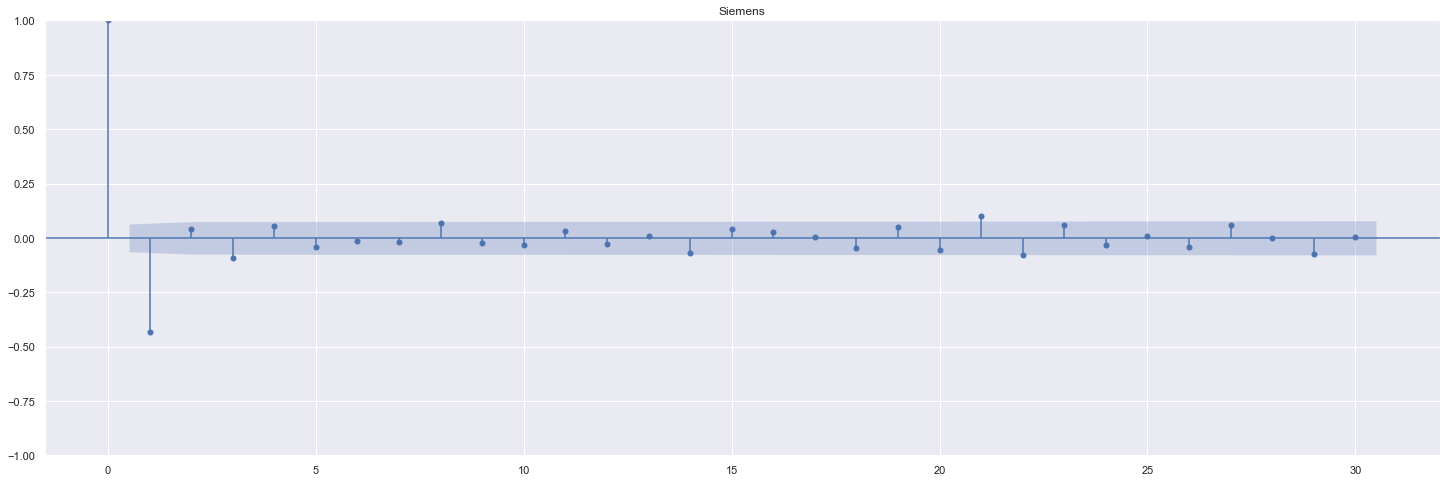

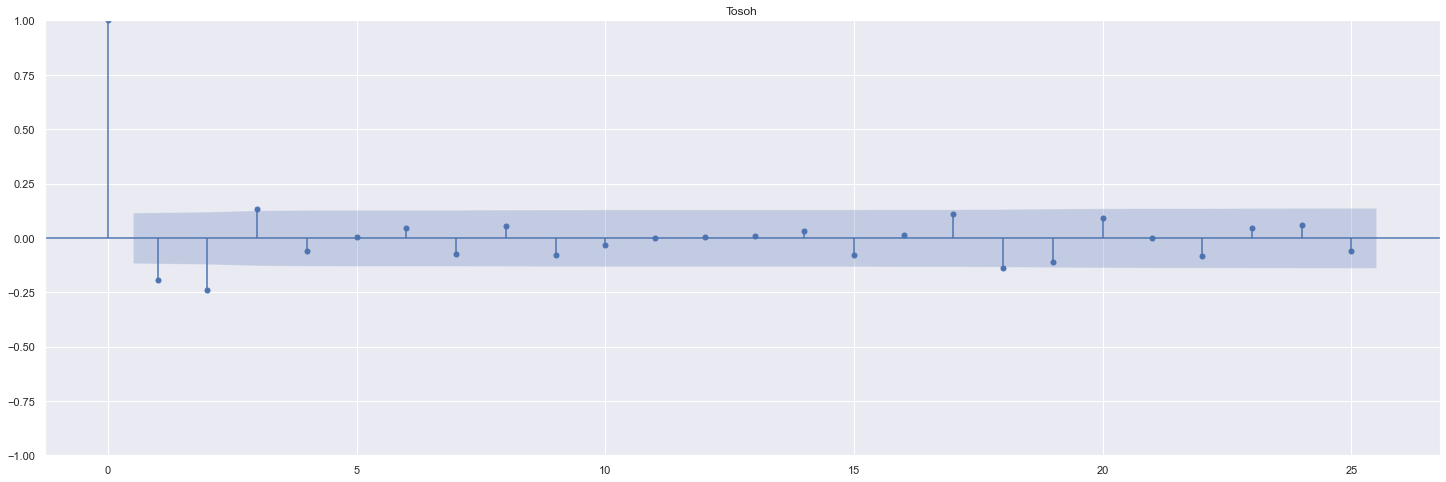

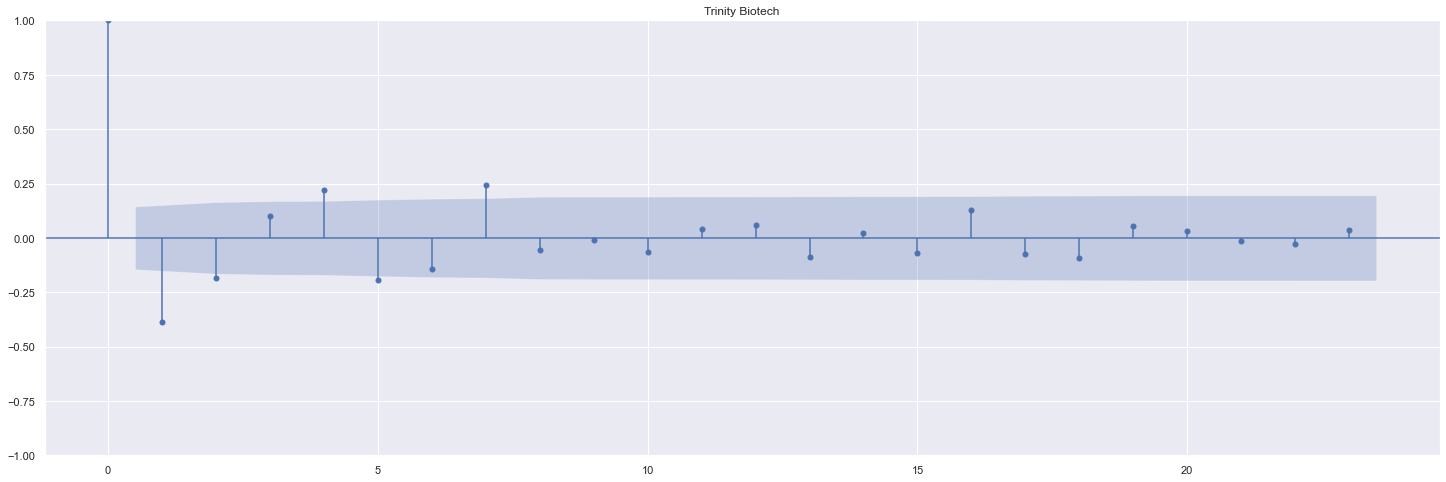

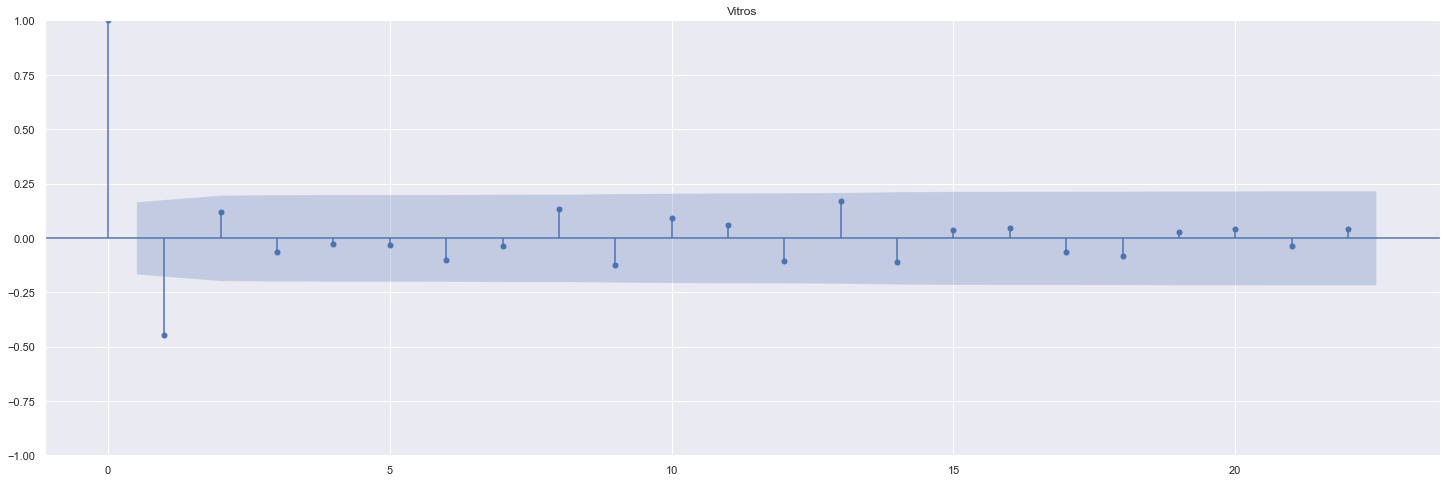

In [60]:
from statsmodels.graphics.tsaplots import plot_acf
for name, data in manufacturers: 
    acf =plot_acf(data['Total'].diff().dropna(), title=name, alpha=.05)

# Analayse acf plot met differentiëren
Na het differentiëren ziet de acf plot er gelijk beter uit. Zo is er een verdeling tussen positieve en negatieve waarden en vallen de meeste datapunten binnen het onzekerheidsgebied.

In [61]:
#This list is created by just counting the data points that are outside the confidence interval
# Lijst_MA = [13,2,11,13,26,5,15,8,7,2]
Lijst_MA = [3,2,1,6,4,1,2,2,5,1]

# Pacf plot

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.w

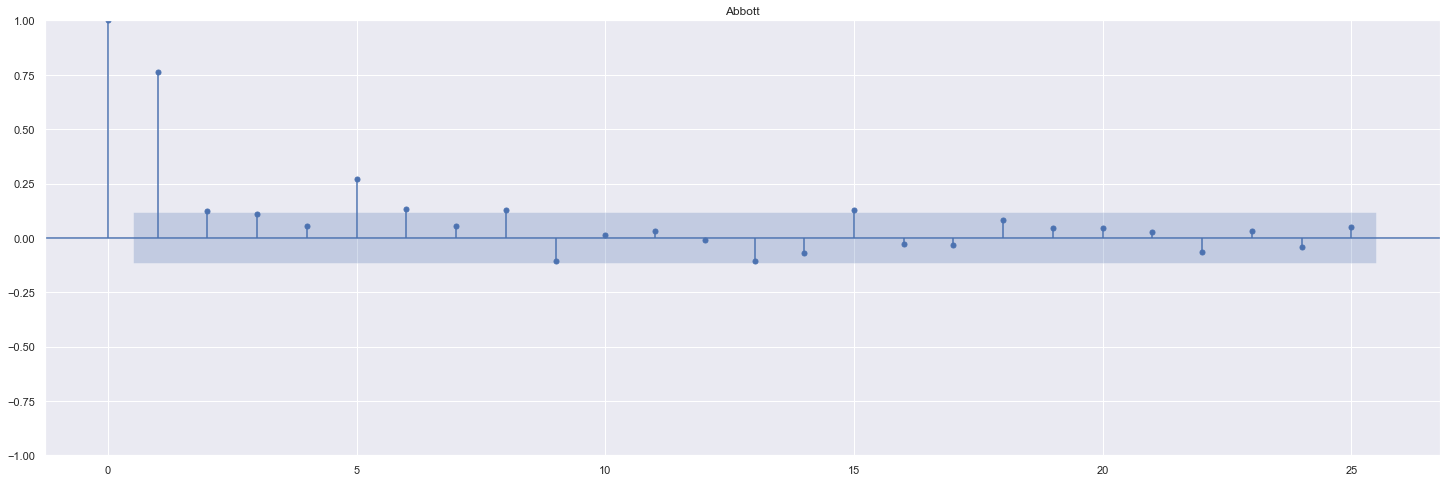

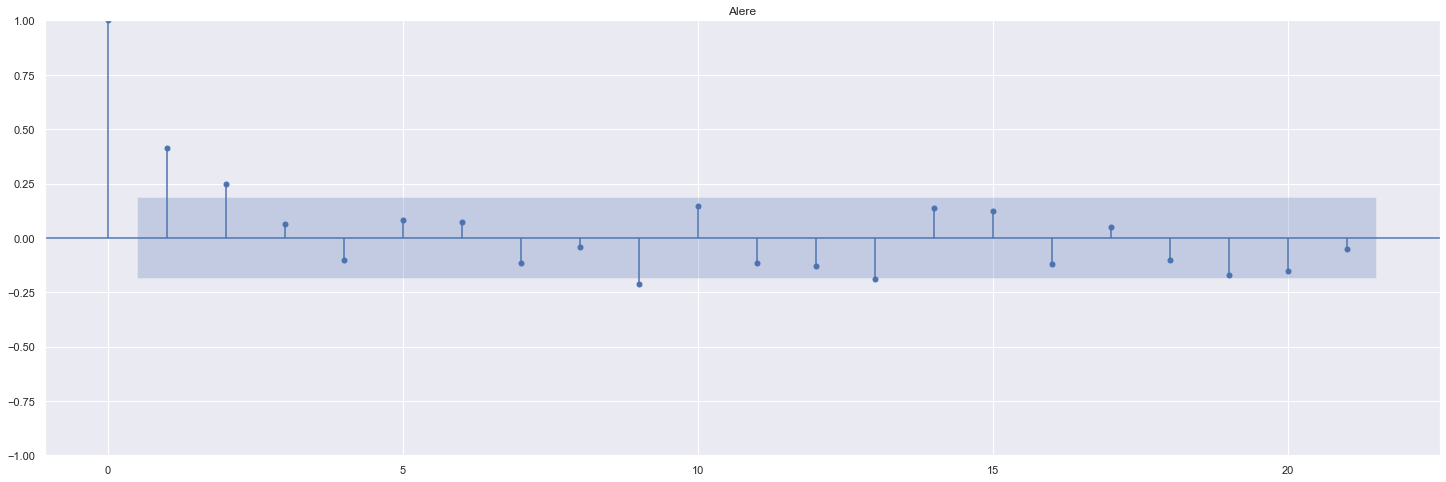

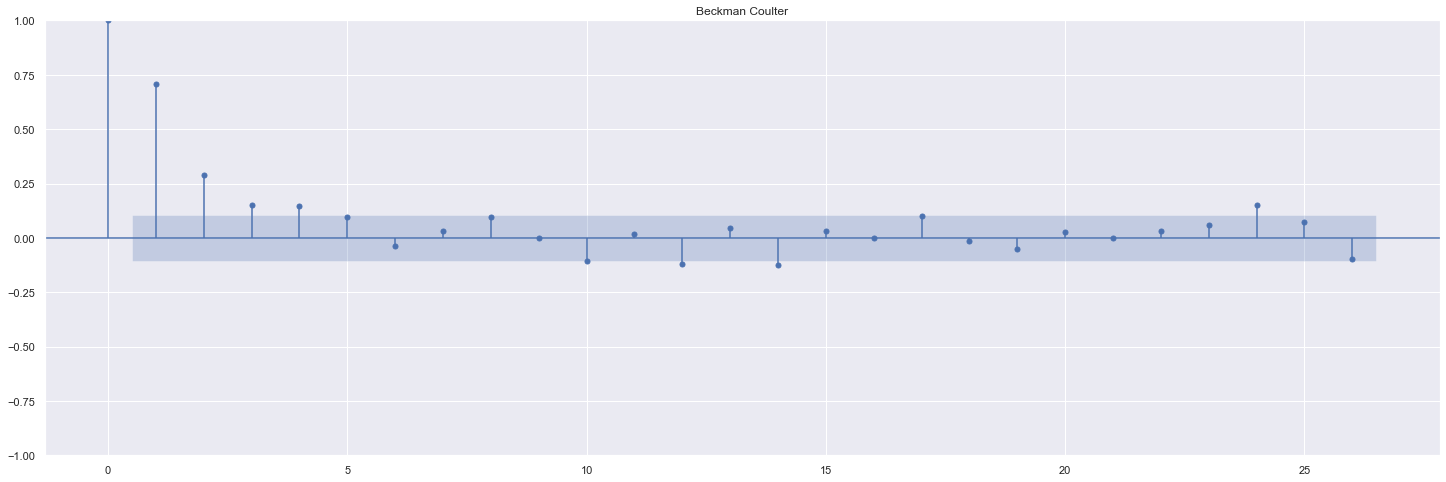

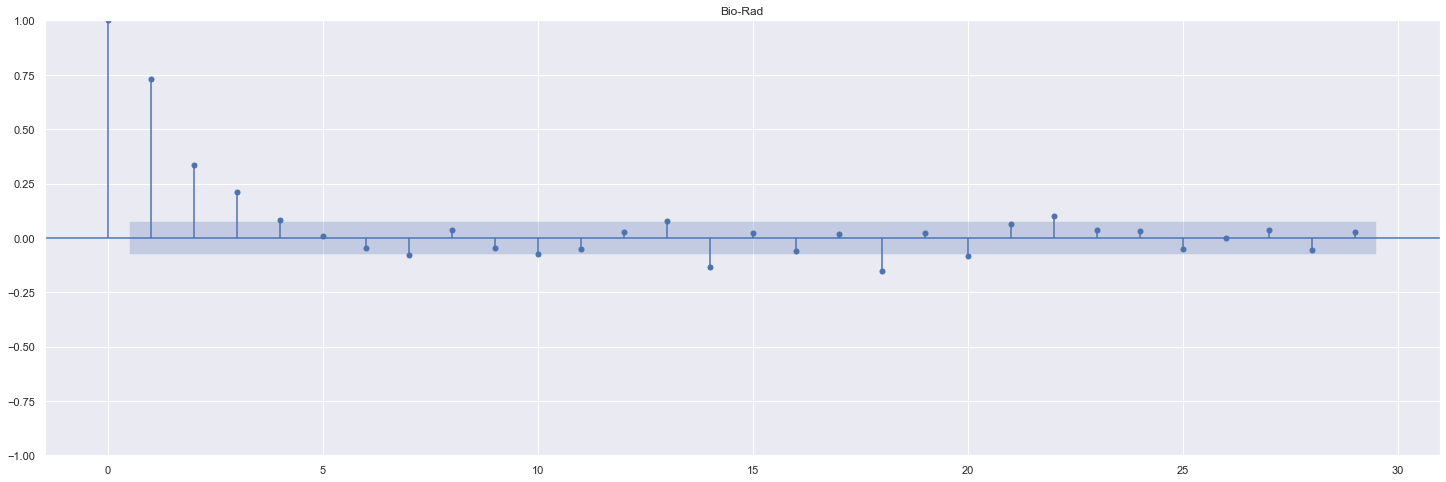

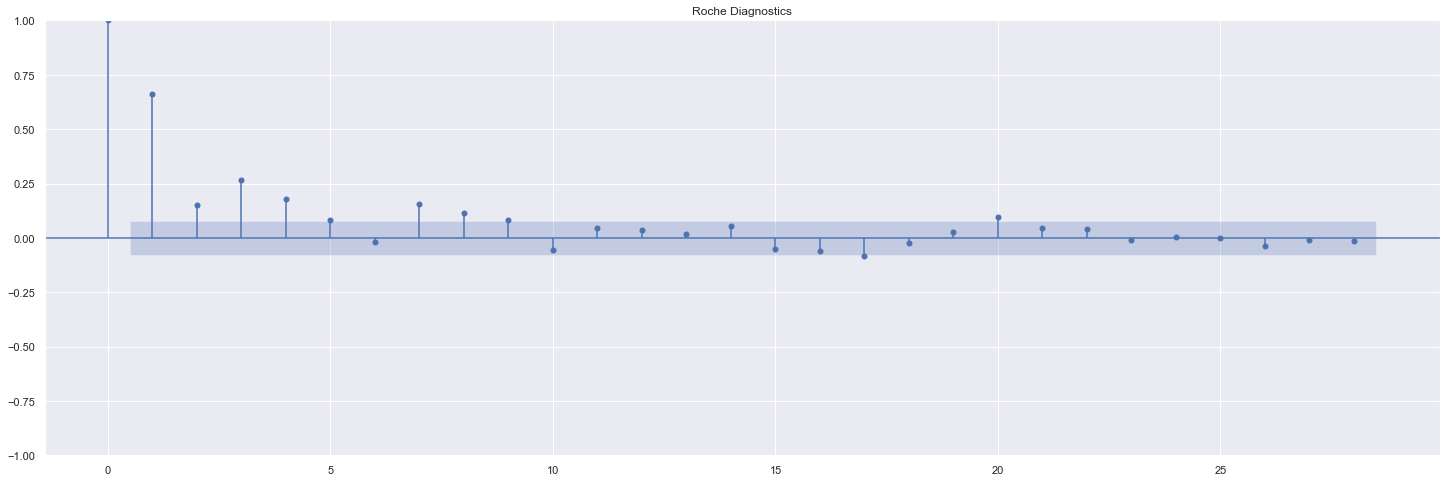

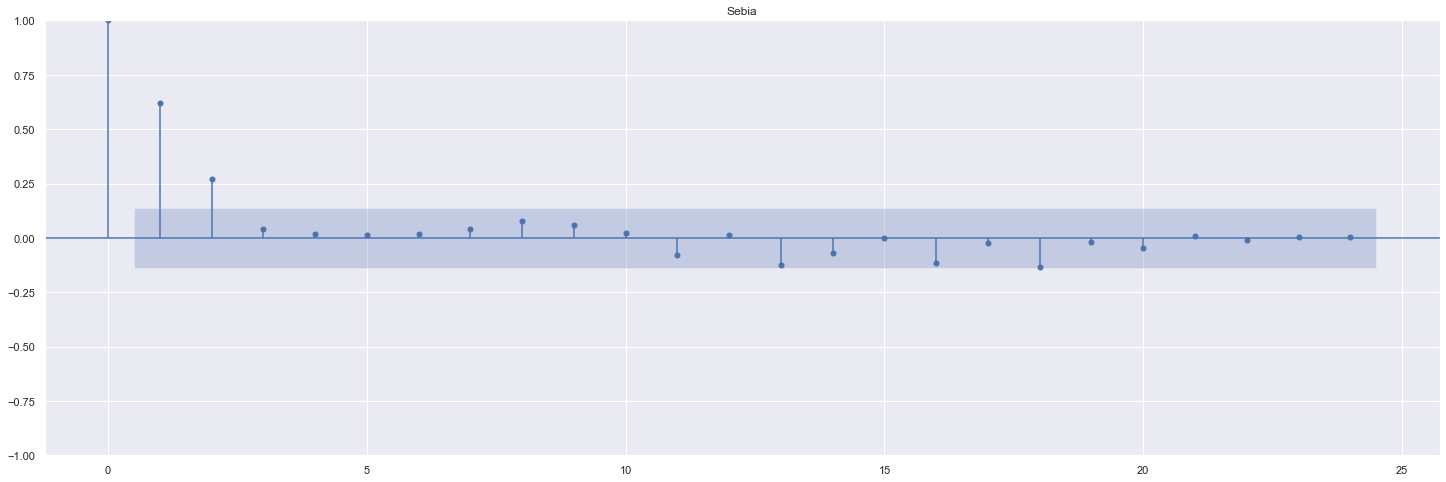

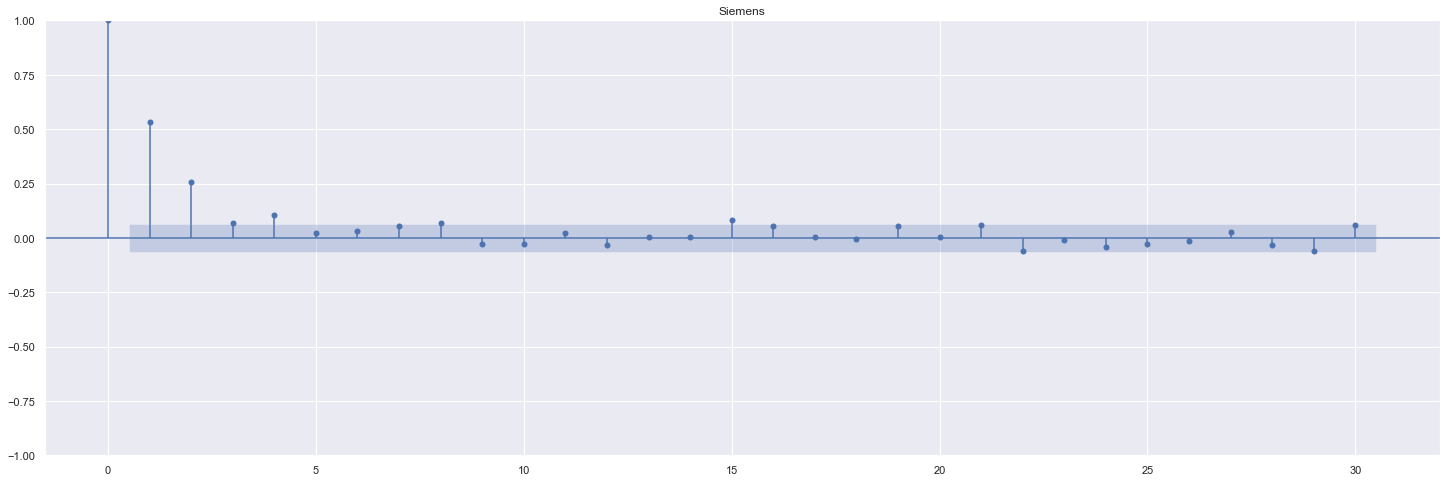

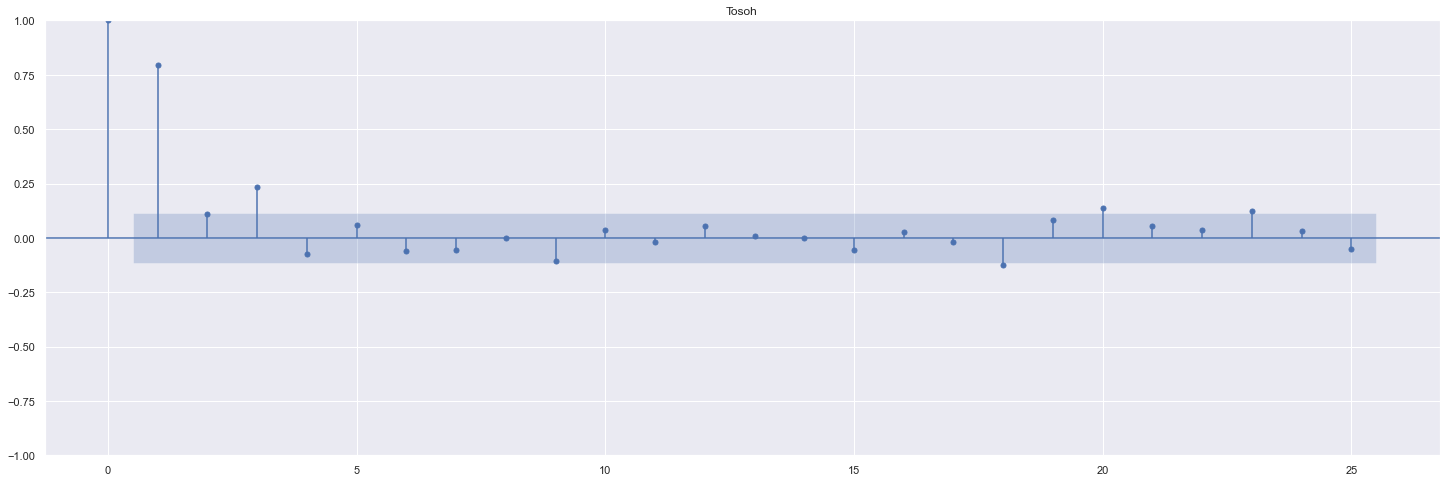

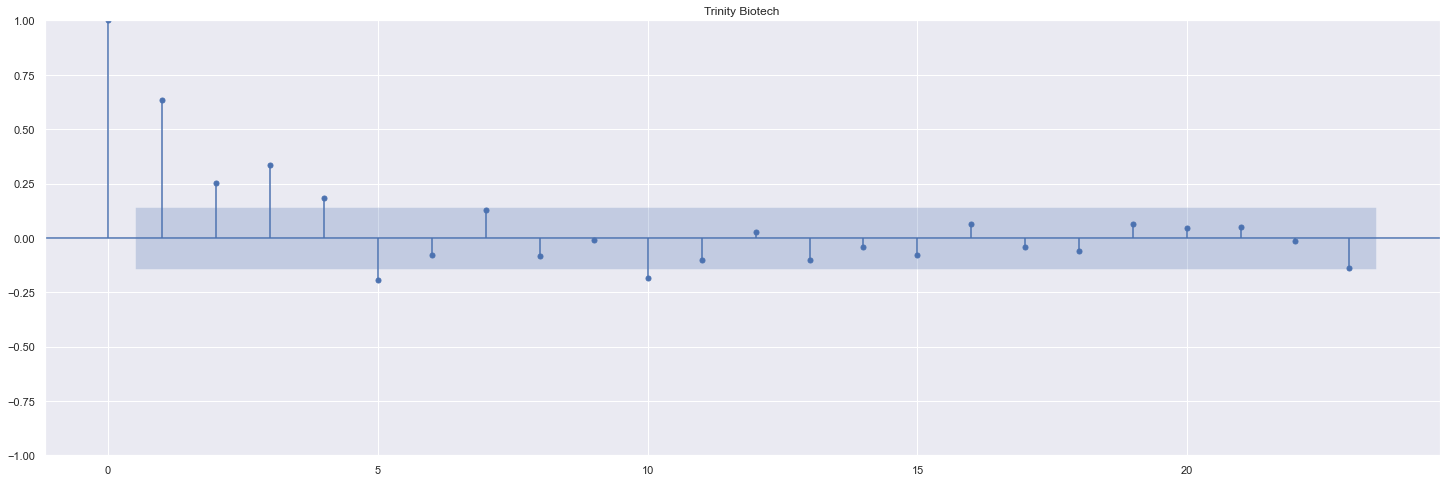

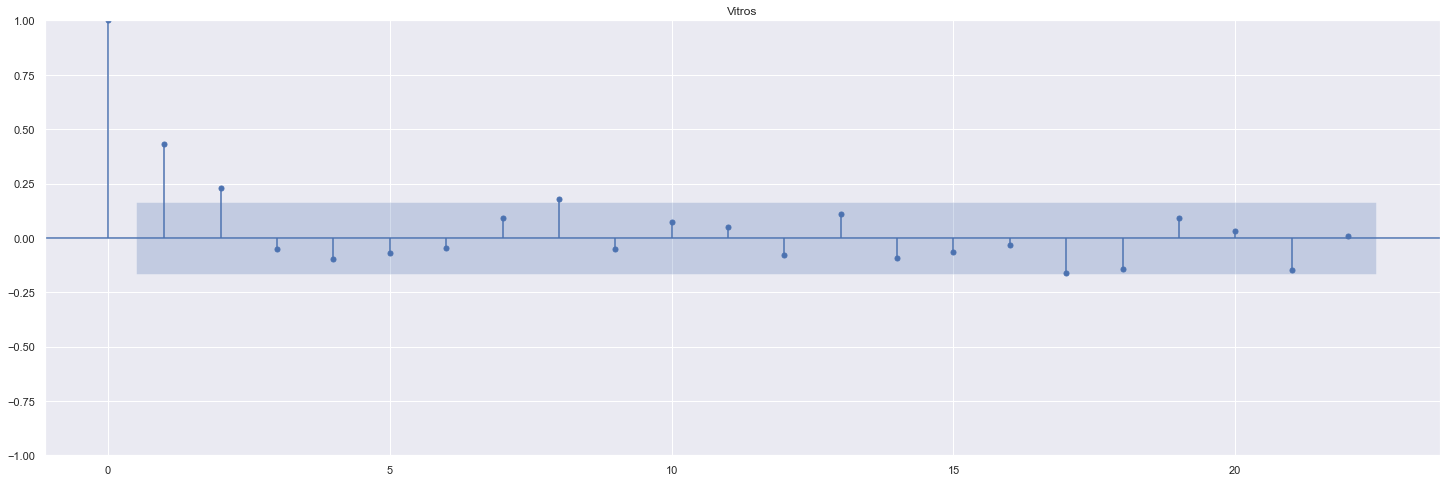

In [62]:
from statsmodels.graphics.tsaplots import plot_pacf

for name, data in manufacturers: 
    pacf = plot_pacf(data['Total'], title=name)

### Analyse van pacf plot
De partiële autocorrelatie geeft weer hoe sterk het verband is tussen de waarde van een lag en de waarde van voorgaande lags. Als er tussen de lags nog significante correlatie bestaat is dit een aanwijzing dat er auto-correlatie optreed en dat het instellen van de AR parameter een goed idee is.

Bij alle grafieken is te zien dat de eerste lag het meest significant is. Daarom nemen we p met de waarde 1. Dus ARIMA(p=1,d=0,q=lijst_MA)

# ARIMA modeling

In [63]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import datetime

## ARIMA summary output

In [64]:
counter= 0

for name, data in manufacturers:
    print(name)
    data.index = pd.DatetimeIndex(data.index).to_period('M')

    model = sm.tsa.arima.ARIMA(data['Total'].diff().dropna(), order=(0,2,Lijst_MA[counter]))
    model_fit = model.fit()
    print(model_fit.summary())
    counter = counter +1
    
   
#P>|z| significant? onder 0.01

Abbott


C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  277
Model:                 ARIMA(0, 2, 3)   Log Likelihood                -668.307
Date:                Wed, 25 May 2022   AIC                           1344.614
Time:                        12:46:05   BIC                           1359.081
Sample:                             0   HQIC                          1350.420
                                - 277                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.3375      1.493     -1.566      0.117      -5.263       0.588
ma.L2          1.6855      2.008      0.839      0.401      -2.251       5.622
ma.L3         -0.3439      0.514     -0.670      0.5

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  348
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -930.195
Date:                Wed, 25 May 2022   AIC                           1864.390
Time:                        12:46:05   BIC                           1872.083
Sample:                             0   HQIC                          1867.453
                                - 348                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9998      2.211     -0.452      0.651      -5.334       3.335
sigma2        12.4568     27.556      0.452      0.651     -41.552      66.466
Ljung-Box (L1) (Q):                 138.94   Jarque-

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  666
Model:                 ARIMA(0, 2, 6)   Log Likelihood               -1160.757
Date:                Wed, 25 May 2022   AIC                           2335.513
Time:                        12:46:06   BIC                           2367.001
Sample:                             0   HQIC                          2347.715
                                - 666                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.5572      0.056    -45.660      0.000      -2.667      -2.447
ma.L2          2.1091      0.101     20.811      0.000       1.910       2.308
ma.L3         -0.4836      0.098     -4.949      0.0

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  604
Model:                 ARIMA(0, 2, 4)   Log Likelihood               -1181.871
Date:                Wed, 25 May 2022   AIC                           2373.742
Time:                        12:46:07   BIC                           2395.743
Sample:                             0   HQIC                          2382.305
                                - 604                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.5587      0.022   -117.557      0.000      -2.601      -2.516
ma.L2          1.8679      0.056     33.591      0.000       1.759       1.977
ma.L3         -0.0579      0.052     -1.119      0.2

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  917
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -2073.585
Date:                Wed, 25 May 2022   AIC                           4153.169
Time:                        12:46:07   BIC                           4167.626
Sample:                             0   HQIC                          4158.687
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9972      0.218     -9.170      0.000      -2.424      -1.570
ma.L2          0.9997      0.218      4.586      0.000       0.572       1.427
sigma2         5.3375      1.151      4.637      0.0

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  184
Model:                 ARIMA(0, 2, 5)   Log Likelihood                -294.314
Date:                Wed, 25 May 2022   AIC                            600.628
Time:                        12:46:08   BIC                            619.852
Sample:                             0   HQIC                           608.421
                                - 184                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.5820      6.350     -0.407      0.684     -15.028       9.865
ma.L2          2.0958     10.046      0.209      0.835     -17.593      21.785
ma.L3         -0.2731      3.271     -0.083      0.9

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\

## ARIMA prediction visualisation

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


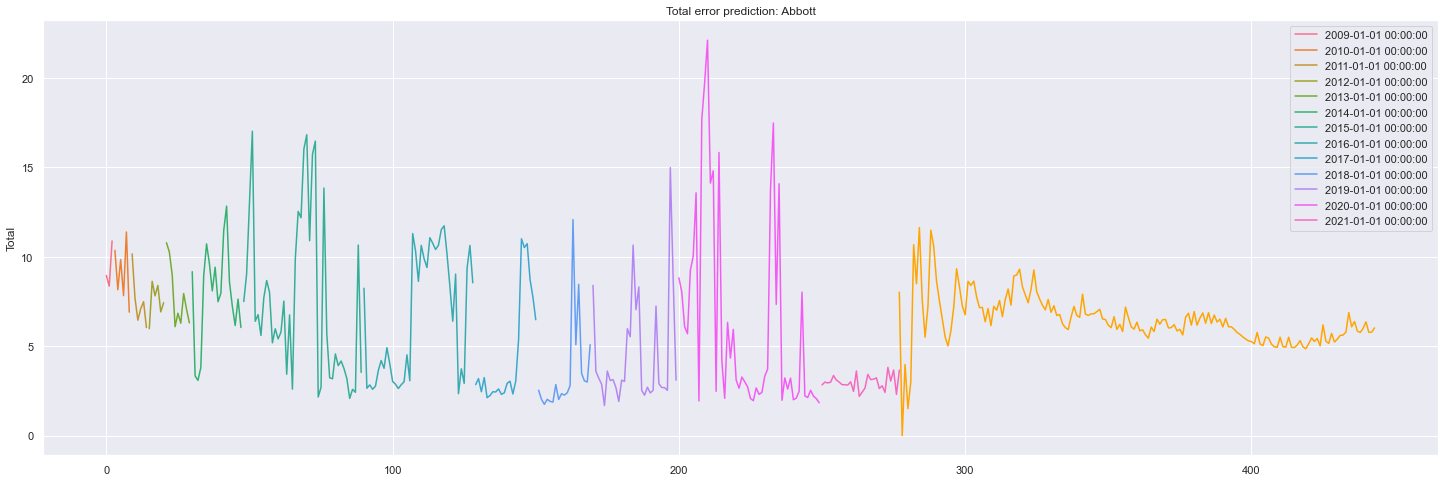

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


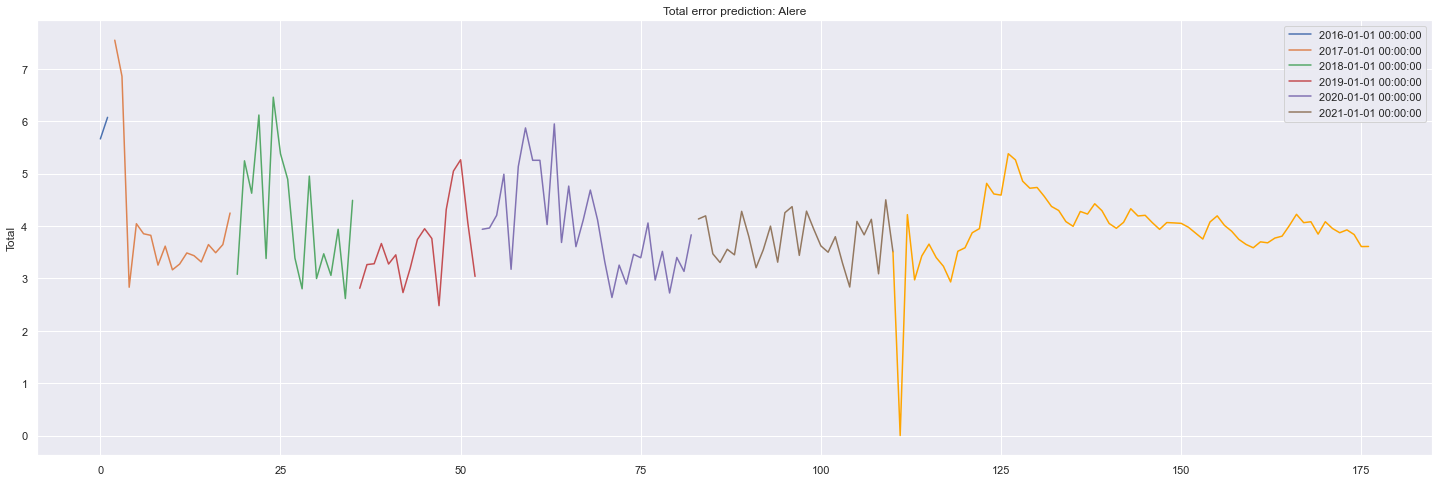

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


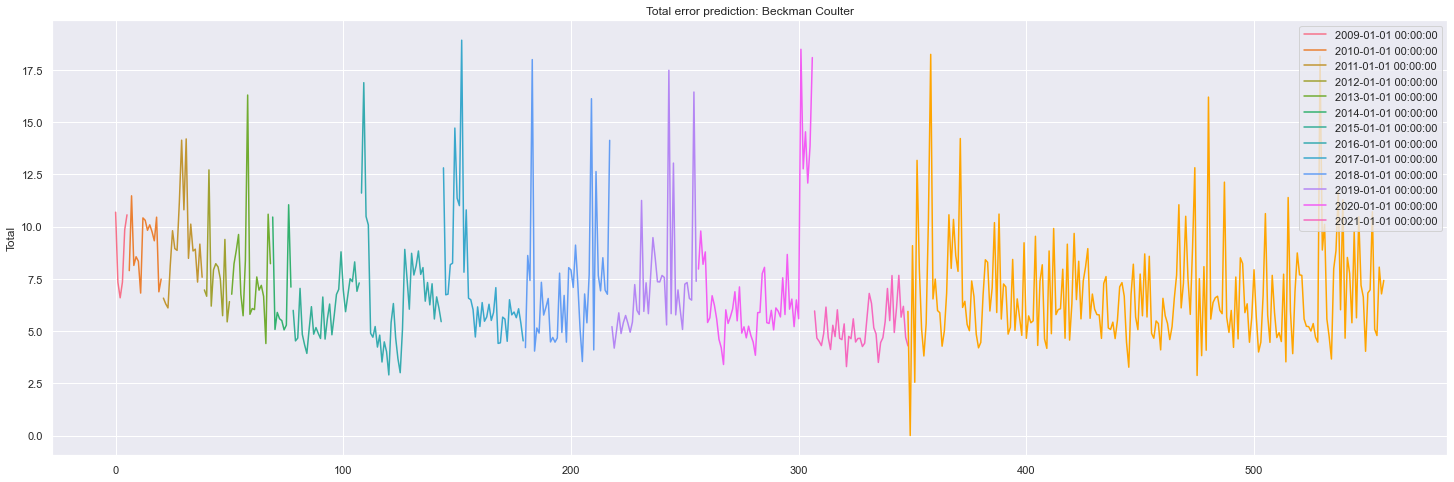

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


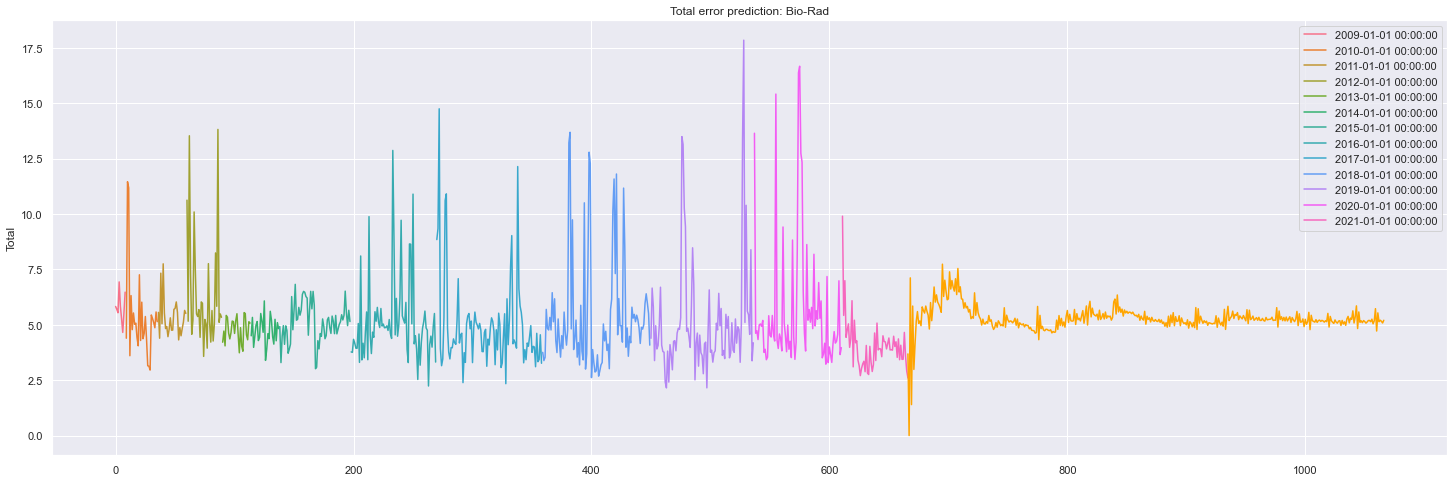

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


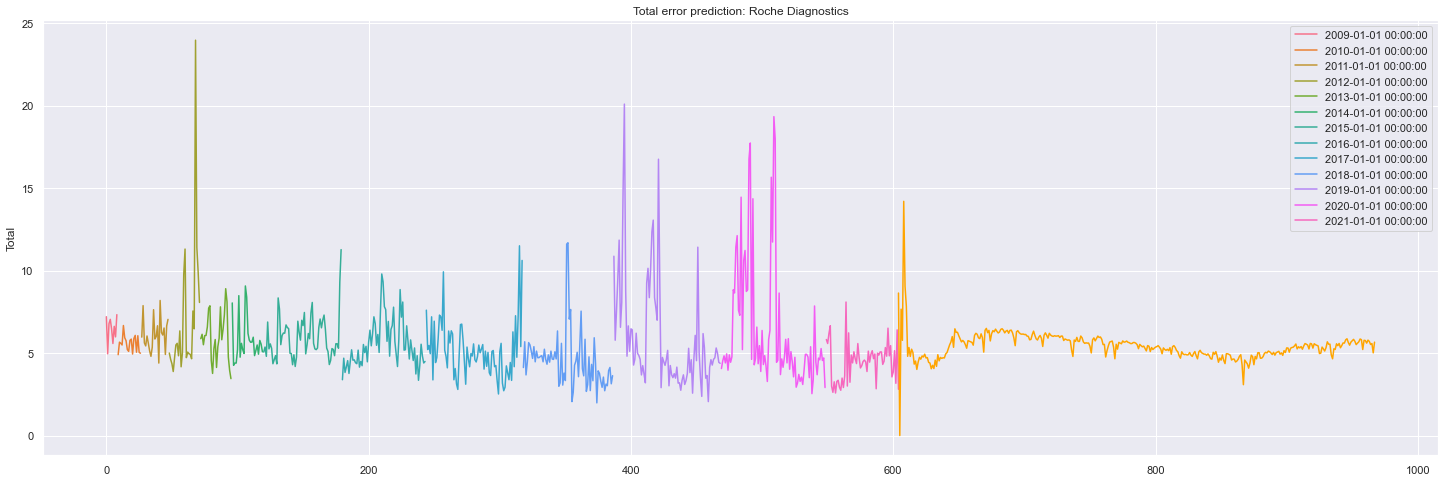

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


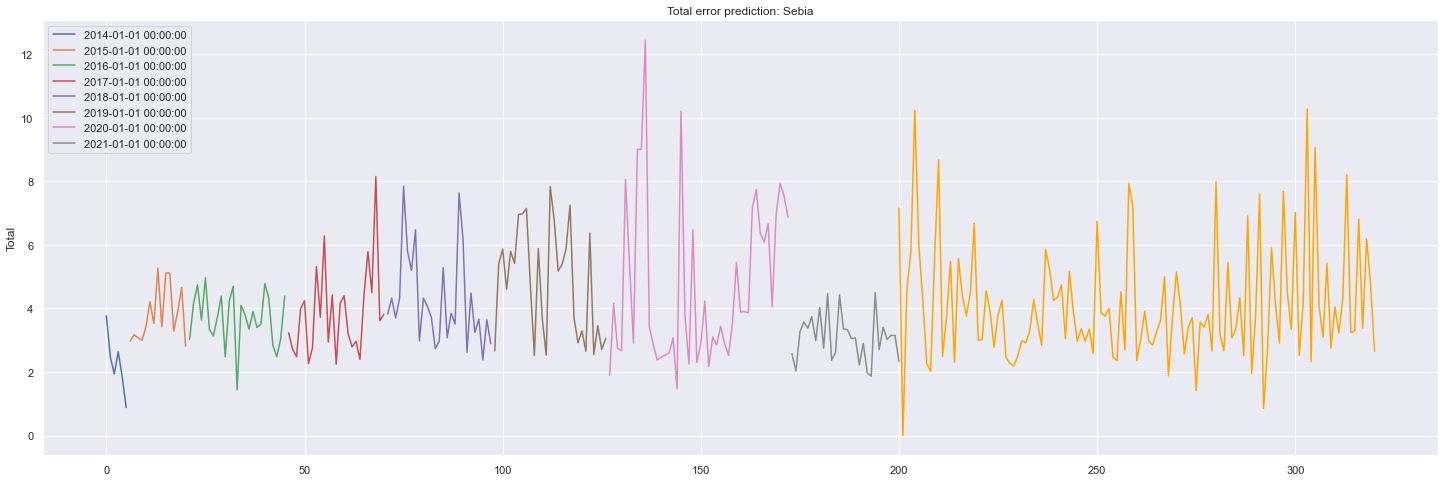

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


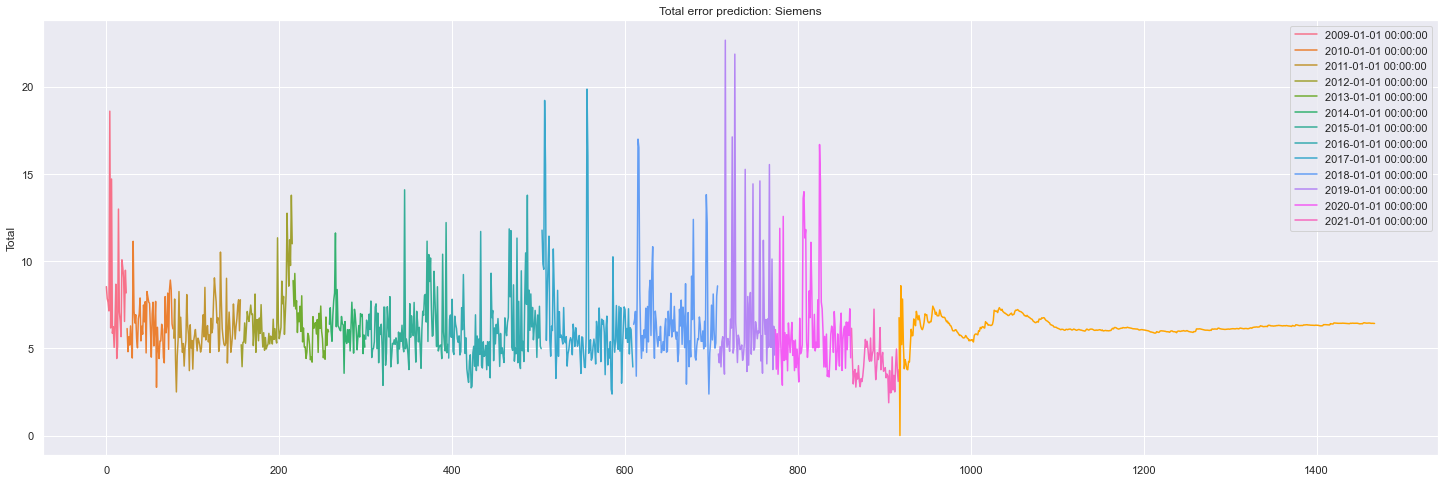

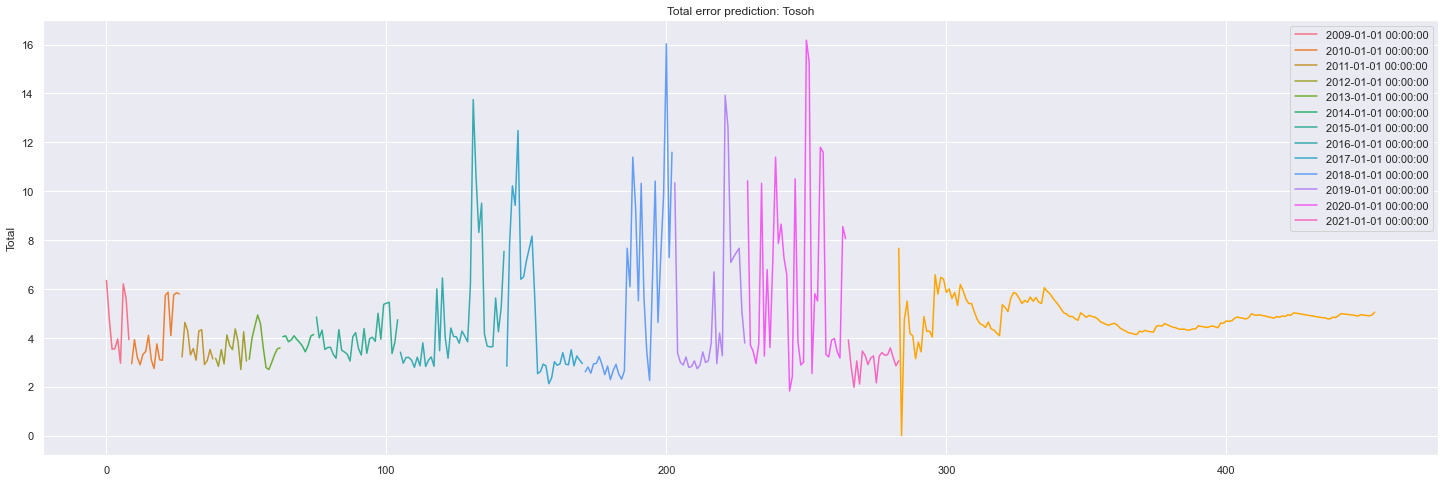

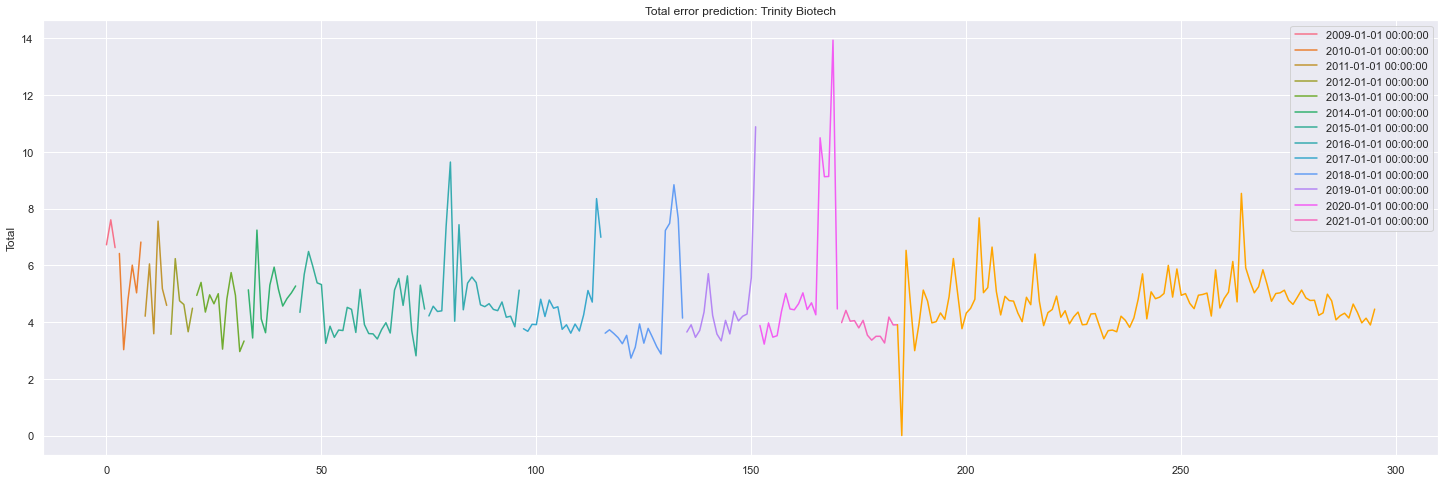

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


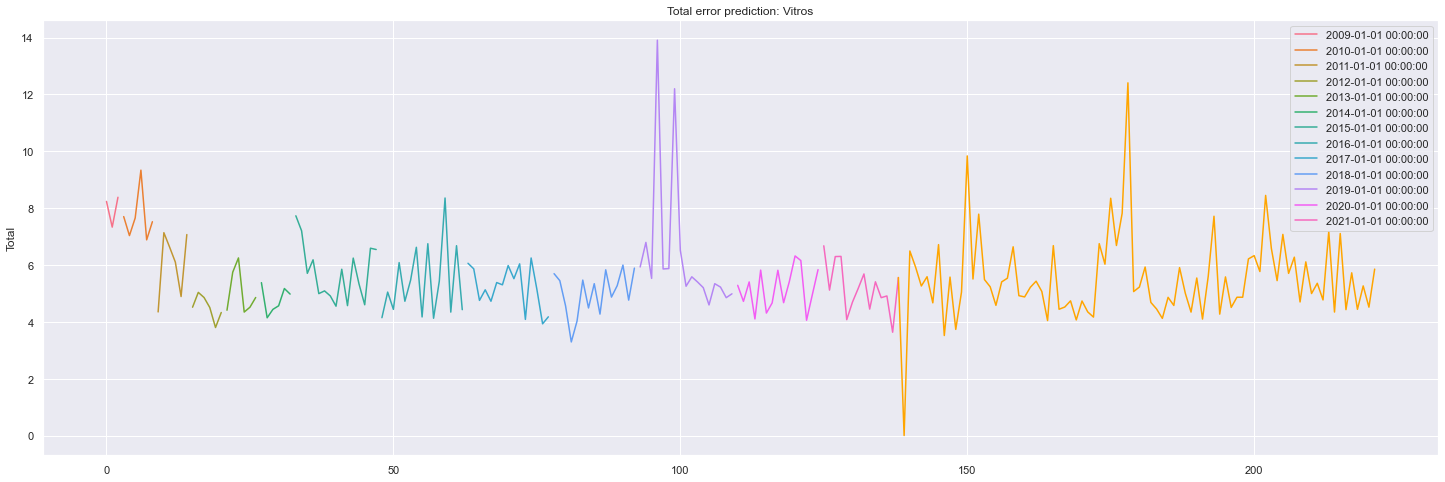

In [65]:
counter= 0
from sklearn.model_selection import train_test_split

import datetime
for name, data in manufacturers:
    tempdf = data[['Total']].dropna()
    X = tempdf.iloc[:, :1].values
    Y = tempdf.index.values
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

    model = sm.tsa.arima.ARIMA(X_train, order=(0,2,Lijst_MA[counter]))
    model_fit = model.fit()
    counter = counter +1 #next in list

    y_pred = model_fit.predict(disp=0, exog=None, dynamic=False)
    length_predicted_values = len(y_pred)


    preddf = pd.DataFrame(y_pred, columns=['Total'])
    preddf['Year'] = pd.to_datetime('2022-01-01')
    preddf = preddf.set_index('Year')
    
    
    # Add tempdf and preddf together and reset index
    tempdf = pd.concat([tempdf, preddf], axis=0)

    tempdf.reset_index(inplace=True)
    
    #find predicted value in concatenated dataframe
    start_index_predValues = max(tempdf.index)-length_predicted_values    
    real_values_df = tempdf.loc[:start_index_predValues]
   
    #sort by year and reset index so all years line up
    real_values_df = real_values_df.sort_values(by="Year")
    real_values_df = real_values_df.reset_index()
    
    l = sns.lineplot(x=real_values_df.index, y='Total', data=real_values_df, hue=real_values_df['Year'])
    l.set_title('Total error prediction: ' + name )
    
    #show predicted values
    predict_values_df = tempdf.loc[start_index_predValues:]
    sns.lineplot(x=predict_values_df.index, y='Total', data=predict_values_df, color='orange')

    sns.set(rc = {'figure.figsize':(25,8)})
    plt.show()

# Evaluation


#### Conclusie
Er zijn bij alle de meetmethoden op aan te merken dat in het jaar 2022 (oranje-lijntje) een sterke daling en stijging wordt voorspeld, waarbij enige meetmethoden nog wat pieken gaan krijgen en dan in sommige gevallen zullen stabiliseren. Bij de 'Abott' en 'Roche diagonistics' meetmethoden zijn de p-waardes niet onder de 0.05. 



#### Advies
Het advies voor de opdrachtgever is derhalve om dit model en deze visualisaties slechts als indicatie te gebruiken. De onderbouwing hiervan zal worden ondersteunt door het FOETSJE-model:

- Financieel: 

    Zijn er genoeg middelen om het plan uit te voeren?     
    Dit valt buiten de scope. Daarnaast kan de opdrachtgever eigen conclusies trekken, passend in het budget.
- Organisatorisch: 

    Is het organisatorisch uitvoerbaar?
    Dit valt buiten de scope. 
- Economisch: 

    Ondersteunen de visualisaties de doelstellingen van de opdrachtgever? 

    De grafieken zijn bedoelt ter ondersteuning om inzicht te creëren, zodat de opdrachtgever concrete conclusies kan trekken.
- Technologisch: 

    Kunnen deze visualisaties leiden tot een technische verandering? 

    Dit valt buiten de scope. 
- Sociaal: 

    Passen de visualisaties binnen de sociale doelstellingen van de opdrachtgever? 

    Deze visualisaties zouden kunnen worden gebruikt om verdere stappen te zetten in het standaardiseren van de diverse meetmethoden.
- Juridisch: 

    Kunnen deze visualisaties leiden tot een juridische verandering? 

    Dit valt buiten de scope.
- Ethisch: 

    Kunnen deze visualisaties leiden tot gepaste, ethische conclusies? 

    Nee, als het gaat om de waarde 'precisie', zullen deze visualisaties niet leiden tot gepaste ethische conclusies. De metingen die in de rapporten staan, zijn genoteerd zonder accurate datums. Hierdoor is de voorspelling gemaakt op data waarvan de datums niet bekend zijn, terwijl deze datums bij het gebruikte model een essentieel component zijn. Door dat deze datums niet zijn meegenomen, is de voorspelling derhalve minder nauwkeurig. Daarom is het advies om deze visualisaties slechts als indicatie te gebruiken en niet als richtlijn. 

    
